In [109]:
#---------------------------------------------------------------------------------------------------#
# IMPORTS
#---------------------------------------------------------------------------------------------------#
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import cm
import plotly.io as pio
import plotly.express as px
import plotly.subplots as sp
import math
import re
from pprint import pprint
import pickle
from plotly.subplots import make_subplots
from scipy.stats import mode, pearsonr, norm, ttest_rel, friedmanchisquare, wilcoxon
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate, find_peaks
from scipy.optimize import curve_fit
import gc  # garbage collector for removing large variables from memory instantly 
import importlib  # for force updating changed packages 
import seaborn as sns
import warnings
from typing import Dict, Optional, Tuple, Iterable, List
warnings.filterwarnings('ignore')

try:
    from statsmodels.stats.anova import AnovaRM
    from statsmodels.stats.multitest import multipletests
    STATS_MODELS_AVAILABLE = True
except ImportError:
    STATS_MODELS_AVAILABLE = False
    AnovaRM = None  # type: ignore
    multipletests = None  # type: ignore
    print("⚠️ statsmodels not available. Repeated measures ANOVA will fall back to non-parametric tests.")

# Interactive widgets for dropdowns
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    print("⚠️ ipywidgets not available. Install with: pip install ipywidgets")
    WIDGETS_AVAILABLE = False
%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

# Aligned Data Analysis Notebook

Analyze aligned `.csv` files generated in **SANDBOX_2** to produce mouse-level averages, grand averages with SEM, and a suite of post-alignment calcium signal metrics. The notebook also supports interactive plotting and the new halt vs no-halt comparison workflow.

## What this notebook does
- Loads aligned data for your selected cohort(s) and mice
- Computes per-mouse mean ± SEM traces for key columns
- Builds grand averages with SEM across mice
- Extracts signal features (peak, onset, decay tau) for `z_470_Baseline` and `z_560_Baseline`
- Calculates the 2–8 s post-alignment mean for `z_560_Baseline`
- Optionally saves per-mouse and cohort-level summary CSVs
- Provides interactive grand-average plotting widgets (when `ipywidgets` is available)
- Compares halt vs no-halt conditions with paired statistics and plotting

## How to use it
1. Review **Configuration** and update cohort, mouse selection, event names, and data directories.
2. Run the **Data Loading** cell to load aligned data.
3. Execute the **Analysis** cells to compute metrics and grand averages.
4. (Optional) Enable saving flags to export CSVs with per-mouse metrics and grand averages.
5. Use the **Interactive Grand Average Plotting** cell to explore previously saved grand-average CSVs.
6. Run the **Halt vs No Halt Condition Comparison** section to generate paired plots, statistics, and export CSV summaries per metric.

## Outputs
- **Grand averages CSV:** time-point means plus SEM for each selected column.
- **Signal metric CSVs:** per-mouse feature metrics (peak, onset, decay tau, 2–8 s mean) saved in each experiment folder.
- **Comparison exports:** per-metric statistics, plot data, and figures saved to `halt_vs_no_halt_comparison/` within the experiment day.


In [110]:
#CONFIGURATION SECTION
# ---------------------------------------------------------------------------------------------------#
#Configure all settings here before running the analysis
# EVENT NAME to decide which files to process in the aligned_data folder
event_name = '_No halt_baselined_data.csv'  # Options: '_Apply halt_2s_baselined_data.csv','_Apply halt_2s_right_turns_baselined_data', '_Apply halt_2s_left_turns_baselined_data', '_No halt_right_turns_baselined_data.csv', '_No halt_left_turns_baselined_data.csv'
# Cohort selection
COHORT_OPTIONS = {
    "Cohort1": {
        "mice": ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722', 'B6J2723'],
        "identifier": "Cohort1"
    },
    "Cohort3": {
        "mice": ["B6J2780", "B6J2781", "B6J2783", "B6J2782"],
        "identifier": "Cohort3"
    }
}
#Select cohort
cohort_identifier = "Cohort1"  # Options: "Cohort1" or "Cohort31
# Select which animals to process (subset of the cohort's available mice)
# Leave empty list [] to process all mice in the cohort
selected_mice = ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722']  # Example: ['B6J2717', 'B6J2718'] or [] for all
# Data columns to analyze
selected_columns = [
    'Velocity_0X_Baseline', 'Motor_Velocity_Baseline', 
    'z_470_Baseline', 'z_560_Baseline'
]
# Data directories (add your paths here)
DATA_DIRS = [
    # Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20241125_Cohort1_rotation/Visual_mismatch_day4').expanduser(),
    Path('/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3').expanduser(),
    # Path('/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day4').expanduser(),
    # Path('/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day3').expanduser(),
    # Path('/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day4').expanduser(),
    # # Add more directories as needed
]

# Data directories for the no-halt condition (can span multiple experiment days)
NO_HALT_DATA_DIRS = [
    Path('/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day3').expanduser(),
    Path('/Volumes/RanczLab2/Cohort3_rotation/Visual_mismatch_day4').expanduser(),
]

SAVE_CSV = False      # Save grand averages with SEM as CSV file
SAVE_SIGNAL_METRICS = True
SIGNAL_METRICS_OUTPUT_SUBDIR = DATA_DIRS[0]

# Signal feature metric settings (incorporated from SANDBOX 4 workflow)
SIGNAL_METRIC_COLUMNS = [
    'z_560_Baseline',
]
SIGNAL_METRIC_FEATURES = (
    'peak',
    'onset_time',
    'decay_tau',
    'mean_fluorescence_2_to_8s'
)
# Configure the post-alignment analysis window (seconds relative to alignment time).
# Adjust POST_ALIGNMENT_WINDOW_DURATION to control the length of the comparison interval.
POST_ALIGNMENT_WINDOW_START = 0.0
POST_ALIGNMENT_WINDOW_DURATION = 1.0
POST_ALIGNMENT_WINDOW = (
    POST_ALIGNMENT_WINDOW_START,
    POST_ALIGNMENT_WINDOW_START + POST_ALIGNMENT_WINDOW_DURATION,
)

# Condition comparison (Apply halt vs No halt)
GENERATE_CONDITION_COMPARISON = True
CONDITION_COMPARISON_CONFIG = {
    "Apply_halt_2s": {
        "event_name": "_Apply halt_2s_baselined_data.csv",
        "data_dirs": DATA_DIRS,
        "label": "Apply halt 2s",
        # Let the pipeline auto-discover per-mouse metrics CSVs under data_dirs
        "metrics_csvs": [],
    },
    "No_halt": {
        "event_name": "_No halt_baselined_data.csv",
        "data_dirs": NO_HALT_DATA_DIRS,
        "label": "No halt",
        "metrics_csvs": [],
    },
}
COMPARISON_METRICS = (
    "peak",
    "onset_time",
    "decay_tau",
    "mean_fluorescence_2_to_8s"
)

# ---------------------------------------------------------------------------------------------------#
# # Auto-configure based on cohort selection
# ---------------------------------------------------------------------------------------------------#
if cohort_identifier in COHORT_OPTIONS:
    cohort_info = COHORT_OPTIONS[cohort_identifier]
    available_mice = cohort_info["mice"]
    if not selected_mice:  # If empty, use all mice
        selected_mice = available_mice
    else:  # Filter to only include valid mice for the selected cohort
        filtered_mice = [m for m in selected_mice if m in available_mice]
        ignored_mice = [m for m in selected_mice if m not in available_mice]
        selected_mice = filtered_mice
        if ignored_mice:
            print(f"⏭️ Ignoring mice not in cohort {cohort_identifier}: {ignored_mice}")
    print(f"✅ Cohort: {cohort_identifier}")
    print(f"✅ Available mice: {available_mice}")
    print(f"✅ Selected mice: {selected_mice}")
else:
    raise ValueError(f"Invalid cohort_identifier: {cohort_identifier}. Must be one of {list(COHORT_OPTIONS.keys())}")

# Save options
# SAVE_PICKLE = False  # Save results as pickle file (deprecated - use SAVE_ANIMAL_CSV instead)
# FIXME THIS IS REGENERATING SOMETHING BUT IT DOES NOT MAKE SENSE! SAVE_ANIMAL_CSV = False  # Save averaged mismatch aligned data for each animal as CSV
# FIXME WE WILL NOT USE THESE PLOTS FOR NOW!!! GENERATE_PLOTS = True  # Generate plots
# # # Columns to plot
# columns_to_plot = [
#     'Velocity_0X_Baseline', 'Motor_Velocity_Baseline', 
#     'z_470_Baseline', 'z_560_Baseline'
# ]
# # Pre/post comparison plotting options
# FIXME WE WILL NOT USE THESE PLOTS FOR NOW!!! PLOT_PREPOST_FROM_RESULTS = True  # Generate pre/post plots from freshly computed results
# FIXME NEED TO VERIFY WHAT IS GOING ON LOAD_EXISTING_PREPOST_CSV = False  # Load a previously created cohort_aligned_data_analysis.csv
# FIXME VERIFY WHAT IS GOING ONEXISTING_PREPOST_CSV_PATH = Path('/Users/nora/Desktop/for_poster/cohort_3/cohort_aligned_data_analysis.csv').expanduser()
# PREPOST_SAVE_DIR = None  # Optional custom directory to save pre/post plots

✅ Cohort: Cohort1
✅ Available mice: ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722', 'B6J2723']
✅ Selected mice: ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722']


In [111]:
# DATA LOADING
#---------------------------------------------------------------------------------------------------#
def load_aligned_data(data_dirs, event_name, selected_mice, allowed_mice=None):
    """
    Load aligned data from CSV files for selected mice.
    
    Parameters:
    -----------
    data_dirs : list
        List of data directory paths
    event_name : str
        Event name suffix for CSV files
    selected_mice : list
        List of mouse names explicitly requested (may be empty)
    allowed_mice : list
        Full set of cohort-allowed mice (used when selected_mice is empty)
    
    Returns:
    --------
    loaded_data : dict
        Dictionary with data paths as keys and mouse data as values
    """
    if selected_mice:
        selected_mice_set = set(selected_mice)
    elif allowed_mice:
        selected_mice_set = set(allowed_mice)
    else:
        selected_mice_set = None

    # Collect raw data paths (excluding '_processedData' dirs) and keep only selected/cohort mice when provided
    rawdata_paths = []
    for data_dir in data_dirs:
        path_obj = Path(data_dir)
        if not path_obj.exists():
            continue
        for subdir in path_obj.iterdir():
            if not subdir.is_dir() or subdir.name.endswith('_processedData'):
                continue
            mouse_id = subdir.name.split('-')[0]
            if selected_mice_set and mouse_id not in selected_mice_set:
                continue
            rawdata_paths.append(subdir)
    
    if not rawdata_paths:
        if selected_mice_set:
            print("⚠️ No matching data directories found for the selected cohort/mice.")
        return {}
    
    # Build processed data paths
    data_paths = [raw.parent / f"{raw.name}_processedData/aligned_data" for raw in rawdata_paths]
    mouse_names = [raw.name.split('-')[0] for raw in rawdata_paths]
    mouse_name_set = set(mouse_names)

    if selected_mice_set:
        filtered_selection = [m for m in selected_mice_set if m in mouse_name_set]
        ignored_selection = [m for m in selected_mice_set if m not in mouse_name_set]
        if ignored_selection:
            print(f"⏭️ Ignoring selected mice not present in data directories: {sorted(ignored_selection)}")
        target_mice = set(filtered_selection)
    else:
        target_mice = mouse_name_set
    
    # Load data
    loaded_data = {}
    for idx, data_path in enumerate(data_paths, start=1):
        mouse_name = mouse_names[idx - 1]
        
        if mouse_name not in target_mice:
            continue
    
        if mouse_name == 'baselined':
            continue
    
        csv_file_path = data_path / f"{mouse_name}{event_name}"
    
        try:
            aligned_df = pd.read_csv(csv_file_path)
            print(f"✅ Loaded {mouse_name}: {csv_file_path}")
            
            loaded_data[data_path] = {
                'mouse_name': mouse_name,
                'data_path': data_path
            }
            
            # Add each column as a separate key
            for column in aligned_df.columns:
                loaded_data[data_path][column] = aligned_df[column].values
            
            del aligned_df
            gc.collect()
            
        except FileNotFoundError:
            continue
    
    return loaded_data

# Load the data
loaded_data = load_aligned_data(DATA_DIRS, event_name, selected_mice, available_mice)

✅ Loaded B6J2717: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3/B6J2717-2024-12-10T12-17-03_processedData/aligned_data/B6J2717_No halt_baselined_data.csv
✅ Loaded B6J2718: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3/B6J2718-2024-12-10T12-57-02_processedData/aligned_data/B6J2718_No halt_baselined_data.csv
✅ Loaded B6J2719: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3/B6J2719-2024-12-10T13-36-31_processedData/aligned_data/B6J2719_No halt_baselined_data.csv
✅ Loaded B6J2721: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3/B6J2721-2024-12-10T14-18-54_processedData/aligned_data/B6J2721_No halt_baselined_data.csv
✅ Loaded B6J2722: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3/B6J2722-2024-12-10T14-58-52_processedData/aligned_data/B6J2722_No halt_baselined_data.csv


In [112]:
# OUTPUT DIRECTORY HELPERS
#---------------------------------------------------------------------------------------------------#

def determine_main_data_dir(loaded_data, data_dirs, cohort_identifier):
    """Select the base data directory corresponding to the loaded cohort data."""
    data_dir_paths = [Path(p).expanduser().resolve() for p in data_dirs]

    loaded_base_dirs = []
    for data_path in loaded_data.keys():
        base_dir = Path(data_path).resolve().parent.parent
        if base_dir not in loaded_base_dirs:
            loaded_base_dirs.append(base_dir)

    if not loaded_base_dirs:
        for candidate in data_dir_paths:
            if candidate.exists():
                return candidate
        return Path.cwd()

    cohort_id = (cohort_identifier or "").lower()
    if cohort_id:
        for candidate in data_dir_paths:
            candidate_resolved = Path(candidate).resolve()
            if candidate_resolved in loaded_base_dirs and cohort_id in str(candidate_resolved).lower():
                return candidate_resolved

    for candidate in data_dir_paths:
        candidate_resolved = Path(candidate).resolve()
        if candidate_resolved in loaded_base_dirs:
            return candidate_resolved

    return loaded_base_dirs[0]

def extract_experiment_day(base_dir: Path) -> str:
    """Derive experiment day label from the selected base directory."""
    if not base_dir or not isinstance(base_dir, Path):
        return "unknown"
    return base_dir.name or "unknown"


def sanitize_for_filename(value: Optional[str], fallback: str = "unknown") -> str:
    """Convert a string into a filesystem-friendly fragment."""
    if value is None:
        return fallback
    cleaned = re.sub(r"[^A-Za-z0-9_-]+", "_", str(value)).strip("_")
    return cleaned or fallback


def build_grand_average_filename(cohort_id: str, experiment_day: str, event_name: str) -> str:
    """Compose the output filename for grand average CSV exports."""
    cohort_part = sanitize_for_filename(cohort_id, "cohort")
    day_part = sanitize_for_filename(experiment_day, "day")
    event_label = sanitize_for_filename(event_name.replace(".csv", ""), "event")
    return f"{cohort_part}_{day_part}_grand_averages_with_sem_{event_label}.csv"



In [113]:
# ANALYSIS FUNCTIONS
#---------------------------------------------------------------------------------------------------#

def compute_mouse_means_and_grand_average(loaded_data, selected_columns, main_data_dir, selected_mice):
    """
    Compute means per mouse and grand averages across selected mice for selected columns.
    
    Parameters:
    loaded_data (dict): Dictionary with data paths as keys and mouse data as values
    selected_columns (list): List of column names to analyze
    main_data_dir (str/Path): Main directory to save results
    selected_mice (list): List of mouse names to include in the grand average
    
    Returns:
    tuple: (mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems, mouse_to_data_path)
        mouse_to_data_path: Dictionary mapping mouse names to their data_path (aligned_data folder)
    """
    
    main_data_dir = Path(main_data_dir)
    
    loaded_mouse_names = [data['mouse_name'] for data in loaded_data.values()]
    loaded_mouse_set = set(loaded_mouse_names)

    if selected_mice:
        filtered_selection = [m for m in selected_mice if m in loaded_mouse_set]
        ignored_selection = [m for m in selected_mice if m not in loaded_mouse_set]
        if ignored_selection:
            print(f"⏭️ Ignoring selected mice without loaded data: {ignored_selection}")
        selected_mice = filtered_selection
    else:
        selected_mice = loaded_mouse_names

    if not selected_mice:
        print("⚠️ No mice available for grand average computation.")
        return {}, {}, pd.DataFrame(), pd.DataFrame(), {}
    
    print(f"Processing selected columns: {selected_columns}")
    
    # Step 1: Compute mean and SEM for each mouse
    mean_data_per_mouse = {}
    sem_data_per_mouse = {}
    mouse_to_data_path = {}  # Track data_path for each mouse
    
    for data_path, data in loaded_data.items():
        mouse_name = data['mouse_name']
        if mouse_name not in selected_mice:
            continue
        
        print(f"Processing mouse: {mouse_name}")
        
        # Track data_path for this mouse
        mouse_to_data_path[mouse_name] = data_path
        
        # Create DataFrame from the loaded data
        df = pd.DataFrame(data)
        
        # Check which selected columns are available
        available_columns = [col for col in selected_columns if col in df.columns]
        missing_columns = [col for col in selected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Missing columns for {mouse_name}: {missing_columns}")
        
        if 'Time (s)' not in df.columns:
            print(f"⚠️  'Time (s)' column not found for {mouse_name}, skipping...")
            continue
        
        # Group by time and compute mean and SEM
        grouped = df.groupby('Time (s)')
        
        # Only use numeric columns that are in our selected list
        numeric_selected = []
        for col in available_columns:
            if col != 'Time (s)' and pd.api.types.is_numeric_dtype(df[col]):
                numeric_selected.append(col)
        
        if len(numeric_selected) == 0:
            print(f"⚠️  No numeric columns found for {mouse_name}")
            continue
        
        mean_data_per_mouse[mouse_name] = grouped[numeric_selected].mean()
        sem_data_per_mouse[mouse_name] = grouped[numeric_selected].sem()
        
        print(f"✅ Processed {len(numeric_selected)} columns for {mouse_name}")
    
    # Step 2: Compute grand averages across selected mice
    print(f"\n📊 Computing grand averages across {len(mean_data_per_mouse)} selected mice...")
    
    # Get all unique time points
    all_time_points = set()
    for mouse_data in mean_data_per_mouse.values():
        all_time_points.update(mouse_data.index)
    all_time_points = sorted(list(all_time_points))
    
    # Get all columns that were successfully processed
    all_processed_columns = set()
    for mouse_data in mean_data_per_mouse.values():
        all_processed_columns.update(mouse_data.columns)
    all_processed_columns = sorted(list(all_processed_columns))
    
    print(f"Time points: {len(all_time_points)} from {min(all_time_points):.2f}s to {max(all_time_points):.2f}s")
    print(f"Processed columns: {all_processed_columns}")
    
    # Create grand average DataFrame
    grand_averages = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_averages.index.name = 'Time (s)'
    
    grand_sems = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_sems.index.name = 'Time (s)'
    
    # Compute grand averages for each column and time point
    for col in all_processed_columns:
        for time_point in all_time_points:
            # Collect data from all selected mice for this time point and column
            mouse_values = []
            for mouse_name, mouse_data in mean_data_per_mouse.items():
                if time_point in mouse_data.index and col in mouse_data.columns:
                    value = mouse_data.loc[time_point, col]
                    if not pd.isna(value):
                        mouse_values.append(value)
            
            if len(mouse_values) > 0:
                grand_averages.loc[time_point, col] = np.mean(mouse_values)
                if len(mouse_values) > 1:
                    grand_sems.loc[time_point, col] = np.std(mouse_values) / np.sqrt(len(mouse_values))
                else:
                    grand_sems.loc[time_point, col] = 0
    
    return mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems, mouse_to_data_path

def analyze_mice_data(loaded_data, selected_columns, main_data_dir):
    """
    Complete analysis workflow: compute means, grand averages, save CSV, and create plots.
    
    Parameters:
    loaded_data (dict): Your loaded_data dictionary
    selected_columns (list): List of column names to analyze (including 'Time (s)')
    main_data_dir (str/Path): Main directory to save results
    
    Returns:
    dict: Complete results including individual and grand averages
    """
    
    print(f"\n{'='*60}")
    print(f"MOUSE DATA ANALYSIS")
    print(f"{'='*60}")
    
    # Use the selected_mice from the configuration (defined in Cell 2)
    # Compute means and grand averages
    mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems, mouse_to_data_path = compute_mouse_means_and_grand_average(
        loaded_data, selected_columns, main_data_dir, selected_mice
    )

    # Print summary
    print(f"\n📊 ANALYSIS COMPLETE:")
    print(f"   • Number of mice analyzed: {len(mean_data_per_mouse)}")
    print(f"   • Mouse names: {list(mean_data_per_mouse.keys())}")
    print(f"   • Columns processed: {list(grand_averages.columns)}")
    print(f"   • Time range: {grand_averages.index.min():.2f}s to {grand_averages.index.max():.2f}s")
    print(f"   • Files saved in: {main_data_dir}")
    
    # Return all results
    results = {
        'mean_data_per_mouse': mean_data_per_mouse,
        'sem_data_per_mouse': sem_data_per_mouse,
        'grand_averages': grand_averages,
        'grand_sems': grand_sems,
        'mouse_to_data_path': mouse_to_data_path,
    }
    
    return results

In [114]:
# FIXME why this?# RUN ANALYSIS
# #---------------------------------------------------------------------------------------------------#

# def save_animal_csv_files(mean_data_per_mouse, sem_data_per_mouse, mouse_to_data_path, event_name, experiment_day):
#     """
#     Save averaged mismatch aligned data for each animal as individual CSV files.
#     Files are saved in each animal's aligned_data folder (same location as SANDBOX 2 output).
    
#     Parameters:
#     -----------
#     mean_data_per_mouse : dict
#         Dictionary with mouse names as keys and DataFrames with mean data as values
#     sem_data_per_mouse : dict
#         Dictionary with mouse names as keys and DataFrames with SEM data as values
#     mouse_to_data_path : dict
#         Dictionary mapping mouse names to their data_path (aligned_data folder)
#     event_name : str
#         Event name for the analysis (used in filename)
#     experiment_day : str
#         Experiment day identifier (e.g., "Visual_mismatch_day3")
#     """
#     print(f"\n{'='*60}")
#     print(f"SAVING ANIMAL CSV FILES")
#     print(f"{'='*60}")
    
#     for mouse_name, mean_df in mean_data_per_mouse.items():
#         if mouse_name not in sem_data_per_mouse:
#             print(f"⚠️  No SEM data for {mouse_name}, skipping...")
#             continue
        
#         if mouse_name not in mouse_to_data_path:
#             print(f"⚠️  No data_path found for {mouse_name}, skipping...")
#             continue
        
#         # Get the aligned_data folder for this mouse (same as SANDBOX 2)
#         animal_aligned_data_dir = mouse_to_data_path[mouse_name]
        
#         # Ensure the directory exists
#         animal_aligned_data_dir.mkdir(parents=True, exist_ok=True)
        
#         sem_df = sem_data_per_mouse[mouse_name]
        
#         # Create a combined DataFrame with mean and SEM
#         combined_df = mean_df.copy()
#         combined_df.index.name = 'Time (s)'
#         combined_df = combined_df.reset_index()
        
#         # Add SEM columns
#         for col in sem_df.columns:
#             if col in combined_df.columns:
#                 combined_df[f'{col}_SEM'] = sem_df[col].values
        
#         # Generate filename - use naming convention that distinguishes from SANDBOX 2
#         # SANDBOX 2 uses: {mouse_name}_{event_name}_baselined_data.csv
#         # We use: {mouse_name}_{event_name}_mean_sem_averaged.csv
#         # Remove .csv extension and _baselined_data suffix if present
#         event_name_clean = event_name.replace('.csv', '')
#         if event_name_clean.endswith('_baselined_data'):
#             event_name_clean = event_name_clean[:-len('_baselined_data')]
#         csv_filename = animal_aligned_data_dir / f"{mouse_name}{event_name_clean}_mean_sem_averaged.csv"
        
#         # Save to CSV
#         combined_df.to_csv(csv_filename, index=False)
#         print(f"✅ Saved: {csv_filename} ({len(combined_df)} rows, {len(combined_df.columns)} columns)")
    
#     print(f"\n✅ Saved {len(mean_data_per_mouse)} animal CSV files to their respective aligned_data folders")


# def save_cohort_csv_file(mean_data_per_mouse, sem_data_per_mouse, selected_columns, main_data_dir, 
#                          event_name, experiment_day, cohort_identifier):
#     """
#     Save cohort-level CSV file with pre/post averages and SEMs for each animal (similar to cohort behavioral analysis format).
#     This creates a single CSV file that can be merged across cohorts.
    
#     Parameters:
#     -----------
#     mean_data_per_mouse : dict
#         Dictionary with mouse names as keys and DataFrames with mean data as values
#     sem_data_per_mouse : dict
#         Dictionary with mouse names as keys and DataFrames with SEM data as values
#     selected_columns : list
#         List of column names to analyze (excluding 'Time (s)')
#     main_data_dir : Path
#         Main data directory (experiment day level)
#     event_name : str
#         Event name for the analysis
#     experiment_day : str
#         Experiment day identifier (e.g., "Visual_mismatch_day3")
#     cohort_identifier : str
#         Cohort identifier (e.g., "Cohort1", "Cohort3")
#     """
#     # Navigate to cohort level (2 levels above _processedData if needed)
#     # The main_data_dir should already be at the experiment day level
#     # We need to go up to the cohort level
#     cohort_dir = main_data_dir.parent if ('_processedData' in str(main_data_dir) or 
#                                           'Visual_mismatch' in str(main_data_dir) or 
#                                           'Vestibular_mismatch' in str(main_data_dir)) else main_data_dir
    
#     # Create cohort CSV path (similar to cohort_behavioral_analysis.csv)
#     cohort_csv_path = cohort_dir / "cohort_aligned_data_analysis.csv"
    
#     print(f"\n{'='*60}")
#     print(f"SAVING COHORT-LEVEL CSV")
#     print(f"{'='*60}")
#     print(f"Cohort CSV path: {cohort_csv_path}")
    
#     # Define pre and post time windows
#     pre_time = (-2, 0)
#     post_time = (0, 2)
    
#     # Collect data for each mouse
#     cohort_data = []
    
#     for mouse_name, mean_df in mean_data_per_mouse.items():
#         if mouse_name not in sem_data_per_mouse:
#             print(f"⚠️  No SEM data for {mouse_name}, skipping...")
#             continue
        
#         sem_df = sem_data_per_mouse[mouse_name]
        
#         # Create row data with Animal_ID and Experiment_Day as first columns
#         row_data = {
#             'Animal_ID': mouse_name,
#             'Experiment_Day': experiment_day
#         }
        
#         # For each selected column, calculate pre and post averages and SEMs
#         for col in selected_columns:
#             if col == 'Time (s)':
#                 continue
            
#             if col not in mean_df.columns or col not in sem_df.columns:
#                 print(f"⚠️  Column {col} not found for {mouse_name}, skipping...")
#                 continue
            
#             # Get pre-time window data
#             pre_mask = (mean_df.index >= pre_time[0]) & (mean_df.index < pre_time[1])
#             if pre_mask.any():
#                 pre_mean = mean_df.loc[pre_mask, col].mean()
#                 pre_sem = sem_df.loc[pre_mask, col].mean()  # Average SEM across pre window
#             else:
#                 pre_mean = np.nan
#                 pre_sem = np.nan
            
#             # Get post-time window data
#             post_mask = (mean_df.index >= post_time[0]) & (mean_df.index <= post_time[1])
#             if post_mask.any():
#                 post_mean = mean_df.loc[post_mask, col].mean()
#                 post_sem = sem_df.loc[post_mask, col].mean()  # Average SEM across post window
#             else:
#                 post_mean = np.nan
#                 post_sem = np.nan
            
#             # Convert velocity to cm/s if column is a velocity column
#             if 'Velocity' in col or 'velocity' in col.lower():
#                 if not pd.isna(pre_mean):
#                     pre_mean = pre_mean * 100  # Convert m/s to cm/s
#                 if not pd.isna(pre_sem):
#                     pre_sem = pre_sem * 100
#                 if not pd.isna(post_mean):
#                     post_mean = post_mean * 100
#                 if not pd.isna(post_sem):
#                     post_sem = post_sem * 100
            
#             # Add columns for this metric: pre_mean, pre_sem, post_mean, post_sem
#             row_data[f'{col}_pre_mean'] = pre_mean
#             row_data[f'{col}_pre_sem'] = pre_sem
#             row_data[f'{col}_post_mean'] = post_mean
#             row_data[f'{col}_post_sem'] = post_sem
        
#         cohort_data.append(row_data)
    
#     # Convert to DataFrame
#     cohort_df = pd.DataFrame(cohort_data)
    
#     # Ensure Animal_ID and Experiment_Day are first columns
#     if len(cohort_df) > 0:
#         cols = ['Animal_ID', 'Experiment_Day'] + [col for col in cohort_df.columns 
#                                                    if col not in ['Animal_ID', 'Experiment_Day']]
#         cohort_df = cohort_df[cols]
    
#     # Check if file exists and append or create new (similar to behavioral analyzer)
#     if cohort_csv_path.exists():
#         print(f"📄 Existing cohort CSV found, loading...")
#         existing_df = pd.read_csv(cohort_csv_path)
        
#         # Check if columns match
#         existing_cols = set(existing_df.columns)
#         new_cols = set(cohort_df.columns)
        
#         if existing_cols != new_cols:
#             print(f"⚠️  Column mismatch detected:")
#             print(f"   Columns in existing file: {sorted(existing_cols)}")
#             print(f"   Columns in new data: {sorted(new_cols)}")
            
#             # Add missing columns to existing data
#             for col in new_cols - existing_cols:
#                 existing_df[col] = np.nan
#                 print(f"   ➕ Added missing column: {col}")
            
#             # Add missing columns to new data
#             for col in existing_cols - new_cols:
#                 cohort_df[col] = np.nan
#                 print(f"   ➕ Added missing column to new data: {col}")
        
#         # Remove rows with matching Animal_ID and Experiment_Day (to avoid duplicates)
#         for _, row in cohort_df.iterrows():
#             animal_id = row['Animal_ID']
#             exp_day = row['Experiment_Day']
            
#             mask = (existing_df['Animal_ID'] == animal_id) & (existing_df['Experiment_Day'] == exp_day)
#             if mask.any():
#                 print(f"   🔄 Overwriting existing data for {animal_id} - {exp_day}")
#                 existing_df = existing_df[~mask]
        
#         # Append new data
#         combined_df = pd.concat([existing_df, cohort_df], ignore_index=True)
        
#         # Sort by Animal_ID and Experiment_Day
#         combined_df = combined_df.sort_values(['Animal_ID', 'Experiment_Day']).reset_index(drop=True)
        
#         print(f"   ✅ Appended {len(cohort_df)} rows to existing data")
#         print(f"   📊 Total rows in cohort CSV: {len(combined_df)}")
        
#     else:
#         print(f"📄 Creating new cohort CSV file...")
#         combined_df = cohort_df
#         print(f"   ✅ Created new file with {len(combined_df)} rows")
    
#     # Save to CSV
#     combined_df.to_csv(cohort_csv_path, index=False)
#     print(f"✅ Saved cohort CSV: {cohort_csv_path}")
#     print(f"   Columns: {list(combined_df.columns)}")
#     if len(combined_df) > 0:
#         print(f"   Animals: {combined_df['Animal_ID'].unique().tolist()}")
#     print(f"{'='*60}\n")


# def save_results(results, filename='results.pkl'):
#     """Save results to a pickle file (deprecated - use CSV functions instead)."""
#     with open(filename, 'wb') as f:
#         pickle.dump(results, f)
#     print(f"✅ Results saved to {filename}")



In [115]:
# # FIXME why this? SAVE RESULTS
# #---------------------------------------------------------------------------------------------------#

# # Extract experiment day from main_data_dir path
# # The experiment day is typically the directory name (e.g., "Visual_mismatch_day3")
# experiment_day = main_data_dir.name

# if results and SAVE_ANIMAL_CSV:
#     # Save individual animal CSV files
#     save_animal_csv_files(
#         results['mean_data_per_mouse'],
#         results['sem_data_per_mouse'],
#         results['mouse_to_data_path'],
#         event_name,
#         experiment_day
#     )
    
#     # Save cohort-level CSV file with pre/post averages and SEMs
#     save_cohort_csv_file(
#         results['mean_data_per_mouse'],
#         results['sem_data_per_mouse'],
#         selected_columns,
#         main_data_dir,
#         event_name,
#         experiment_day,
#         cohort_identifier
#     )
# else:
#     print("⏭️  Skipping animal CSV save (SAVE_ANIMAL_CSV=False or no results)")

# # Legacy pickle save (deprecated)
# if results and SAVE_PICKLE:
#     # Generate unique filename
#     vmm_event_name = main_data_dir.name
#     pickle_filename = f"{cohort_identifier}_{vmm_event_name}{event_name.replace('.csv', '')}.pkl"
#     save_results(results, pickle_filename)
#     print("⚠️  Note: Pickle saving is deprecated. Use SAVE_ANIMAL_CSV instead.")

In [116]:
# FIXME not needed # PLOTTING FUNCTIONS
# #---------------------------------------------------------------------------------------------------#

# def plot_time_series_and_scatter(results, columns_to_plot, selected_mice, main_data_dir, event_name):
#     """
#     Plot time series and pre/post comparison plots for each column.
#     Includes paired t-test and converts velocity to cm/s.
#     Uses gnuplot2 color palette for consistent mouse colors.
#     """
#     # Plot properties
#     plt.rcParams.update({
#         'font.size': 10,
#         'font.family': 'sans-serif',
#         'font.sans-serif': ['DejaVu Sans'],
#         'axes.titlesize': 10,
#         'axes.labelsize': 10,
#         'legend.fontsize': 8,
#         'xtick.labelsize': 10,
#         'ytick.labelsize': 10
#     })
    
#     # Generate color palette using gnuplot2 (same as cohort running analysis)
#     # Get ALL unique mice from results (not just selected) to ensure consistent color assignment
#     # This matches the approach in cohort running analysis which uses all mice from the dataframe
#     all_mice_in_results = sorted(results.get('mean_data_per_mouse', {}).keys())
#     if not all_mice_in_results:
#         # Fallback: use selected_mice if no results yet
#         all_mice_in_results = sorted(selected_mice)
#     n_colors = len(all_mice_in_results) if all_mice_in_results else len(selected_mice)
#     # Use gnuplot2 color palette (similar to gnuplot's default palette)
#     # Avoid the white end (value 1.0) by using 0 to 0.95 instead of 0 to 1
#     if n_colors > 0:
#         colors = plt.cm.gnuplot2(np.linspace(0, 0.95, n_colors))
#         mouse_colors = {mouse: colors[i] for i, mouse in enumerate(all_mice_in_results)}
#     else:
#         mouse_colors = {}
#     # Add any missing mice from selected_mice with a default color
#     for mouse in selected_mice:
#         if mouse not in mouse_colors:
#             # Use a default color if mouse not in results
#             mouse_colors[mouse] = 'gray'
    
#     # Helper function to check if column is velocity and convert to cm/s
#     def convert_velocity_if_needed(column_name, value):
#         """Convert velocity from m/s to cm/s if column is a velocity column.
#         Handles both scalars and pandas Series/arrays.
#         """
#         if 'Velocity' in column_name or 'velocity' in column_name.lower():
#             if isinstance(value, (pd.Series, np.ndarray)):
#                 return value * 100  # Convert m/s to cm/s for arrays/Series
#             else:
#                 return value * 100  # Convert m/s to cm/s for scalars
#         return value
    
#     # Helper function to get ylabel with correct units
#     def get_ylabel(column_name):
#         """Get ylabel with correct units."""
#         if 'Velocity' in column_name or 'velocity' in column_name.lower():
#             return column_name.replace('_', ' ') + ' (cm/s)'
#         return column_name.replace('_', ' ')
    
#     for column_to_plot in columns_to_plot:
#         if column_to_plot not in results['grand_averages'].columns:
#             print(f"⚠️ Column {column_to_plot} not found in results, skipping...")
#             continue
        
#         print(f"\n📊 Plotting: {column_to_plot}")
        
#         # Time series plot
#         plt.figure(figsize=(8, 4))
#         mice_plotted = []
        
#         for mouse in selected_mice:
#             if mouse in results['mean_data_per_mouse']:
#                 mice_plotted.append(mouse)
#                 mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
#                 sem_data = results['sem_data_per_mouse'][mouse][column_to_plot]
                
#                 mean_data = pd.to_numeric(mean_data, errors='coerce')
#                 sem_data = pd.to_numeric(sem_data, errors='coerce')
#                 time_points = pd.to_numeric(mean_data.index, errors='coerce')
                
#                 valid_mask = ~(pd.isna(mean_data) | pd.isna(sem_data) | pd.isna(time_points))
#                 mean_data_clean = mean_data[valid_mask]
#                 sem_data_clean = sem_data[valid_mask]
#                 time_points_clean = time_points[valid_mask]
                
#                 # Convert velocity to cm/s
#                 mean_data_clean = convert_velocity_if_needed(column_to_plot, mean_data_clean)
#                 sem_data_clean = convert_velocity_if_needed(column_to_plot, sem_data_clean)
                
#                 # Get color for this mouse, with fallback
#                 mouse_color = mouse_colors.get(mouse, 'gray')
#                 plt.plot(time_points_clean, mean_data_clean, label=f'{mouse} Mean', color=mouse_color)
#                 plt.fill_between(time_points_clean, mean_data_clean - sem_data_clean, 
#                                 mean_data_clean + sem_data_clean, color=mouse_color, alpha=0.2)
        
#         # Grand average
#         grand_mean = results['grand_averages'][column_to_plot]
#         grand_sem = results['grand_sems'][column_to_plot]
#         grand_mean = pd.to_numeric(grand_mean, errors='coerce')
#         grand_sem = pd.to_numeric(grand_sem, errors='coerce')
#         time_points = pd.to_numeric(grand_mean.index, errors='coerce')
        
#         valid_mask = ~(pd.isna(grand_mean) | pd.isna(grand_sem) | pd.isna(time_points))
#         grand_mean_clean = grand_mean[valid_mask]
#         grand_sem_clean = grand_sem[valid_mask]
#         time_points_clean = time_points[valid_mask]
        
#         # Convert velocity to cm/s
#         grand_mean_clean = convert_velocity_if_needed(column_to_plot, grand_mean_clean)
#         grand_sem_clean = convert_velocity_if_needed(column_to_plot, grand_sem_clean)
        
#         plt.plot(time_points_clean, grand_mean_clean, label='Grand Average', color='black', linewidth=2)
#         plt.fill_between(time_points_clean, grand_mean_clean - grand_sem_clean, 
#                         grand_mean_clean + grand_sem_clean, color='gray', alpha=0.3)
        
#         plt.xlabel('Time (s)')
#         plt.ylabel(get_ylabel(column_to_plot))
#         plt.title(f'Mean and SEM of {column_to_plot} Over Time')
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
        
#         # Save plot
#         try:
#             baselined_dir = main_data_dir / "baselined"
#             baselined_dir.mkdir(exist_ok=True)
#             plot_filename = baselined_dir / f"{column_to_plot}{event_name.replace('.csv', '')}.pdf"
#             plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
#             print(f"   ✅ Saved: {plot_filename}")
#         except Exception as e:
#             print(f"   ⚠️ Error saving plot: {e}")
        
#         plt.show()
        
#         # Pre/post comparison plot with paired t-test
#         pre_time = (-2, 0)
#         post_time = (0, 2)
        
#         pre_values, post_values, mouse_labels = [], [], []
        
#         for mouse in selected_mice:
#             if mouse in results['mean_data_per_mouse']:
#                 mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
#                 # Get pre and post means
#                 pre_mask = (mean_data.index >= pre_time[0]) & (mean_data.index < pre_time[1])
#                 post_mask = (mean_data.index >= post_time[0]) & (mean_data.index <= post_time[1])
                
#                 if pre_mask.any() and post_mask.any():
#                     pre_mean = mean_data.loc[pre_mask].mean()
#                     post_mean = mean_data.loc[post_mask].mean()
                    
#                     # Convert velocity to cm/s
#                     pre_mean = convert_velocity_if_needed(column_to_plot, pre_mean)
#                     post_mean = convert_velocity_if_needed(column_to_plot, post_mean)
                    
#                     # Only add if both values are valid
#                     if not (pd.isna(pre_mean) or pd.isna(post_mean)):
#                         pre_values.append(pre_mean)
#                         post_values.append(post_mean)
#                         mouse_labels.append(mouse)
        
#         # Calculate grand averages
#         grand_mean = results['grand_averages'][column_to_plot]
#         grand_sem = results['grand_sems'][column_to_plot]
        
#         # Get pre and post grand means
#         pre_mask = (grand_mean.index >= pre_time[0]) & (grand_mean.index < pre_time[1])
#         post_mask = (grand_mean.index >= post_time[0]) & (grand_mean.index <= post_time[1])
        
#         if not (pre_mask.any() and post_mask.any()):
#             print(f"   ⚠️ No data in pre/post time windows for grand average, skipping pre/post plot")
#             continue
        
#         pre_grand_mean = grand_mean.loc[pre_mask].mean()
#         post_grand_mean = grand_mean.loc[post_mask].mean()
#         pre_grand_sem = grand_sem.loc[pre_mask].mean()
#         post_grand_sem = grand_sem.loc[post_mask].mean()
        
#         # Check for NaN values
#         if pd.isna(pre_grand_mean) or pd.isna(post_grand_mean):
#             print(f"   ⚠️ Grand average contains NaN values, skipping pre/post plot")
#             continue
        
#         # Convert velocity to cm/s
#         pre_grand_mean = convert_velocity_if_needed(column_to_plot, pre_grand_mean)
#         post_grand_mean = convert_velocity_if_needed(column_to_plot, post_grand_mean)
#         pre_grand_sem = convert_velocity_if_needed(column_to_plot, pre_grand_sem)
#         post_grand_sem = convert_velocity_if_needed(column_to_plot, post_grand_sem)
        
#         # Check if we have data to plot
#         if len(pre_values) == 0 or len(post_values) == 0:
#             print(f"   ⚠️ No valid pre/post data found for {column_to_plot}, skipping pre/post plot")
#             continue
        
#         # Perform paired t-test
#         if len(pre_values) > 1 and len(post_values) > 1:
#             pre_array = np.array(pre_values)
#             post_array = np.array(post_values)
#             # Remove any NaN values for t-test
#             valid_mask = ~(np.isnan(pre_array) | np.isnan(post_array))
#             if np.sum(valid_mask) > 1:
#                 t_stat, p_value = ttest_rel(pre_array[valid_mask], post_array[valid_mask])
#                 print(f"   📊 Paired t-test (pre vs post): t={t_stat:.4f}, p={p_value:.4f}, n={np.sum(valid_mask)}")
#             else:
#                 t_stat, p_value = np.nan, np.nan
#                 print(f"   ⚠️ Not enough valid data for paired t-test")
#         else:
#             t_stat, p_value = np.nan, np.nan
#             print(f"   ⚠️ Not enough data for paired t-test (n={len(pre_values)})")
        
#         # Create pre/post comparison plot
#         fig, ax = plt.subplots(figsize=(6, 5))
        
#         # Plot individual mouse lines
#         for i, mouse in enumerate(mouse_labels):
#             # Get color for this mouse, with fallback
#             mouse_color = mouse_colors.get(mouse, 'gray')
#             ax.plot([0, 1], [pre_values[i], post_values[i]], color=mouse_color, 
#                     marker='o', linewidth=1.5, markersize=6, alpha=0.7, label=mouse)
        
#         # Plot grand average with error bars
#         ax.errorbar([0, 1], [pre_grand_mean, post_grand_mean], 
#                     yerr=[pre_grand_sem, post_grand_sem], fmt='o-', color='black', 
#                     linewidth=2.5, markersize=10, capsize=8, capthick=2, 
#                     label='Grand Average ± SEM', zorder=10)
        
#         ax.set_xticks([0, 1])
#         ax.set_xticklabels([f'Pre\n({pre_time[0]} to {pre_time[1]}s)', 
#                            f'Post\n({post_time[0]} to {post_time[1]}s)'], fontsize=11)
#         ax.set_ylabel(get_ylabel(column_to_plot), fontsize=12, fontweight='bold')
#         ax.set_title(f'{column_to_plot.replace("_", " ")}: Pre vs Post Comparison', 
#                     fontsize=12, fontweight='bold')
#         ax.grid(True, alpha=0.3)
        
#         # Set y-axis limits for velocity if needed
#         if 'Velocity' in column_to_plot or 'velocity' in column_to_plot.lower():
#             # Collect all values, filtering out NaN
#             all_values = [v for v in pre_values + post_values if not np.isnan(v)]
#             all_values.extend([pre_grand_mean - pre_grand_sem, pre_grand_mean + pre_grand_sem,
#                               post_grand_mean - post_grand_sem, post_grand_mean + post_grand_sem])
#             all_values = [v for v in all_values if not np.isnan(v)]
#             if all_values:
#                 y_min = min(all_values) * 0.9
#                 y_max = max(all_values) * 1.1
#                 ax.set_ylim(y_min, y_max)
        
#         # Add t-test result to plot (after ylim is set)
#         if not np.isnan(p_value):
#             significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
#             y_lim = ax.get_ylim()
#             y_pos = y_lim[0] + (y_lim[1] - y_lim[0]) * 0.95
#             ax.text(0.5, y_pos, f'p = {p_value:.4f} {significance}', 
#                    ha='center', va='top', fontsize=11, fontweight='bold',
#                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
#         # Legend
#         handles, labels = ax.get_legend_handles_labels()
#         unique_labels = {}
#         for h, l in zip(handles, labels):
#             if l not in unique_labels:
#                 unique_labels[l] = h
#         ax.legend(unique_labels.values(), unique_labels.keys(), loc='best', fontsize=8, ncol=2)
        
#         plt.tight_layout()
        
#         try:
#             plot_filename = baselined_dir / f"{column_to_plot}{event_name.replace('.csv', '')}_prepost_comparison.pdf"
#             plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
#             print(f"   ✅ Saved pre/post comparison: {plot_filename}")
#         except Exception as e:
#             print(f"   ⚠️ Error saving pre/post comparison plot: {e}")
        
#         plt.show()
#         plt.clf()
#         plt.close()


# #---------------------------------------------------------------------------------------------------#
# # PRE/POST COMPARISON PLOTTING UTILITIES
# #---------------------------------------------------------------------------------------------------#

# def _compute_sem(values: np.ndarray) -> float:
#     """Compute the standard error of the mean for an array, ignoring NaNs."""
#     arr = np.asarray(values, dtype=float)
#     arr = arr[np.isfinite(arr)]
#     if arr.size <= 1:
#         return 0.0 if arr.size == 1 else np.nan
#     return np.nanstd(arr, ddof=1) / np.sqrt(arr.size)


# def _convert_cm_to_inches(cm: float) -> float:
#     """Convert centimeters to inches for matplotlib figsize."""
#     return cm / 2.54


# def _build_mouse_color_map(mouse_labels):
#     """Assign consistent colors to each mouse using the gnuplot2 palette."""
#     unique_mice = sorted(set(mouse_labels))
#     if not unique_mice:
#         return {}
#     colors = plt.cm.gnuplot2(np.linspace(0, 0.95, len(unique_mice)))
#     return {mouse: colors[idx] for idx, mouse in enumerate(unique_mice)}


# def _format_ylabel(column_name: str) -> str:
#     """Return a nicely formatted y-label, including units for relevant columns."""
#     if 'Motor' in column_name and ('Velocity' in column_name or 'velocity' in column_name.lower()):
#         return column_name.replace('_', ' ') + ' (deg/s)'
#     if 'Velocity' in column_name or 'velocity' in column_name.lower():
#         return column_name.replace('_', ' ') + ' (cm/s)'
#     return column_name.replace('_', ' ')


# def _convert_velocity_values(column_name: str, values):
#     """Convert velocity data from m/s to cm/s when necessary."""
#     if ('Velocity' in column_name or 'velocity' in column_name.lower()) and 'Motor' not in column_name:
#         return np.asarray(values, dtype=float) * 100.0
#     return np.asarray(values, dtype=float)


# def _render_prepost_plot(
#     column_to_plot: str,
#     pre_values: np.ndarray,
#     post_values: np.ndarray,
#     mouse_labels,
#     mouse_colors,
#     p_value: float,
#     save_path: Optional[Path] = None,
# ) -> None:
#     """Render a pre/post plot with individual mice and grand average."""
#     pre_values = np.asarray(pre_values, dtype=float)
#     post_values = np.asarray(post_values, dtype=float)

#     # Compute summary statistics
#     pre_mean = np.nanmean(pre_values)
#     post_mean = np.nanmean(post_values)
#     pre_sem = _compute_sem(pre_values)
#     post_sem = _compute_sem(post_values)

#     # Update plotting style
#     plt.rcParams.update({
#         'font.size': 15,
#         'font.family': 'sans-serif',
#         'font.sans-serif': ['Arial'],
#         'axes.titlesize': 15,
#         'axes.labelsize': 15,
#         'legend.fontsize': 12,
#         'xtick.labelsize': 15,
#         'ytick.labelsize': 15
#     })

#     fig, ax = plt.subplots(
#         figsize=(
#             _convert_cm_to_inches(7.0),
#             _convert_cm_to_inches(7.0),
#         )
#     )

#     # Plot individual mice
#     for label, pre_val, post_val in zip(mouse_labels, pre_values, post_values):
#         color = mouse_colors.get(label, 'gray')
#         ax.plot(
#             [0, 1],
#             [pre_val, post_val],
#             color=color,
#             marker='o',
#             linewidth=1.5,
#             markersize=6,
#             alpha=0.7,
#             zorder=1,
#         )

#     # Add SEM shading along the grand mean line
#     x_band = np.linspace(0, 1, 100)
#     upper_band = np.interp(x_band, [0, 1], [pre_mean + pre_sem, post_mean + post_sem])
#     lower_band = np.interp(x_band, [0, 1], [pre_mean - pre_sem, post_mean - post_sem])
#     ax.fill_between(
#         x_band,
#         lower_band,
#         upper_band,
#         color='gray',
#         alpha=0.3,
#         zorder=2,
#     )

#     # Plot grand average line
#     ax.plot(
#         [0, 1],
#         [pre_mean, post_mean],
#         color='black',
#         marker='o',
#         linewidth=2.5,
#         markersize=10,
#         alpha=1,
#         zorder=3,
#         label='Grand Average',
#     )

#     ax.set_xticks([0, 1])
#     ax.set_xticklabels(['Pre', 'Post'], fontsize=15, fontfamily='Arial')
#     ax.set_xlim(-0.4, 1.4)

#     ax.set_ylabel(_format_ylabel(column_to_plot), fontsize=15, fontfamily='Arial')
#     ax.grid(False)

#     # Determine y-limits with padding
#     finite_values = np.concatenate([pre_values, post_values])
#     finite_values = finite_values[np.isfinite(finite_values)]
#     if finite_values.size:
#         data_min = finite_values.min()
#         data_max = finite_values.max()
#         span = data_max - data_min
#         if span == 0:
#             span = max(abs(data_max), 1.0) * 0.1
#         lower = data_min - 0.1 * span
#         upper = data_max + 0.25 * span
#         ax.set_ylim(lower, upper)
#     else:
#         lower, upper = -1, 1.2
#         span = upper - lower
#         ax.set_ylim(lower, upper)

#     # Annotate significance
#     if not np.isnan(p_value):
#         significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
#         y_lim = ax.get_ylim()
#         span = y_lim[1] - y_lim[0]
#         y_pos = y_lim[1] - 0.01 * span
#         ax.text(
#             0.5,
#             y_pos,
#             f'p = {p_value:.3f} {significance}',
#             ha='center',
#             va='top',
#             fontsize=12,
#             fontfamily='Arial',
#         )

#     plt.tight_layout()

#     if save_path:
#         save_path = Path(save_path)
#         save_path.parent.mkdir(parents=True, exist_ok=True)
#         try:
#             fig.savefig(save_path, dpi=300, bbox_inches='tight')
#             print(f"   ✅ Saved: {save_path}")
#         except Exception as exc:
#             print(f"   ⚠️ Error saving plot: {exc}")

#     plt.show()
#     plt.close(fig)


# def plot_prepost_from_results(
#     results: dict,
#     columns_to_plot,
#     selected_mice,
#     pre_time=(-2, 0),
#     post_time=(0, 2),
#     save_dir: Optional[Path] = None,
#     main_data_dir: Optional[Path] = None,
# ) -> None:
#     """Generate pre/post comparison plots using freshly computed results."""
#     if not results:
#         print("⚠️ No results available for pre/post plotting.")
#         return

#     target_dir: Optional[Path]
#     if save_dir is not None:
#         target_dir = Path(save_dir)
#     elif main_data_dir is not None:
#         target_dir = Path(main_data_dir) / "baselined"
#     else:
#         target_dir = None

#     if target_dir is not None:
#         target_dir.mkdir(parents=True, exist_ok=True)

#     mouse_colors = _build_mouse_color_map(selected_mice or results.get('mean_data_per_mouse', {}).keys())

#     for column_to_plot in columns_to_plot:
#         if column_to_plot not in results['grand_averages'].columns:
#             print(f"⚠️ Column {column_to_plot} not found in results, skipping...")
#             continue

#         pre_values = []
#         post_values = []
#         mouse_labels = []

#         for mouse in selected_mice:
#             if mouse not in results['mean_data_per_mouse']:
#                 continue

#             mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
#             pre_mask = (mean_data.index >= pre_time[0]) & (mean_data.index < pre_time[1])
#             post_mask = (mean_data.index >= post_time[0]) & (mean_data.index <= post_time[1])

#             if not (pre_mask.any() and post_mask.any()):
#                 continue

#             pre_mean = mean_data.loc[pre_mask].mean()
#             post_mean = mean_data.loc[post_mask].mean()

#             pre_mean = _convert_velocity_values(column_to_plot, [pre_mean])[0]
#             post_mean = _convert_velocity_values(column_to_plot, [post_mean])[0]

#             if pd.isna(pre_mean) or pd.isna(post_mean):
#                 continue

#             pre_values.append(pre_mean)
#             post_values.append(post_mean)
#             mouse_labels.append(mouse)

#         if not pre_values:
#             print(f"   ⚠️ No valid data found for {column_to_plot}, skipping...")
#             continue

#         pre_array = np.asarray(pre_values, dtype=float)
#         post_array = np.asarray(post_values, dtype=float)

#         if pre_array.size > 1:
#             t_stat, p_value = ttest_rel(pre_array, post_array)
#             print(f"   📊 Paired t-test ({column_to_plot}): t={t_stat:.4f}, p={p_value:.4f}, n={pre_array.size}")
#         else:
#             p_value = np.nan
#             print(f"   ⚠️ Not enough data for paired t-test ({column_to_plot}); n={pre_array.size}")

#         save_path = None
#         if target_dir is not None:
#             safe_name = column_to_plot.replace('/', '_')
#             save_path = target_dir / f"{safe_name}_prepost_comparison.pdf"

#         _render_prepost_plot(
#             column_to_plot=column_to_plot,
#             pre_values=pre_array,
#             post_values=post_array,
#             mouse_labels=mouse_labels,
#             mouse_colors=mouse_colors,
#             p_value=p_value,
#             save_path=save_path,
#         )


# def plot_prepost_from_cohort_csv(
#     cohort_csv_path: Path,
#     columns_to_plot,
#     selected_mice=None,
#     pre_time=(-2, 0),
#     post_time=(0, 2),
#     save_dir: Optional[Path] = None,
# ) -> None:
#     """Generate pre/post comparison plots from an existing cohort_aligned_data_analysis.csv."""
#     cohort_csv_path = Path(cohort_csv_path)
#     if not cohort_csv_path.exists():
#         print(f"⚠️ Cohort CSV not found: {cohort_csv_path}")
#         return

#     df = pd.read_csv(cohort_csv_path)
#     if df.empty:
#         print(f"⚠️ Cohort CSV is empty: {cohort_csv_path}")
#         return

#     if selected_mice:
#         df = df[df['Animal_ID'].astype(str).isin(selected_mice)]
#         if df.empty:
#             print(f"⚠️ No matching animals found in cohort CSV for {selected_mice}")
#             return

#     if save_dir is not None:
#         target_dir = Path(save_dir)
#     else:
#         target_dir = cohort_csv_path.parent / "prepost_plots"
#     target_dir.mkdir(parents=True, exist_ok=True)

#     mouse_labels_all = df['Animal_ID'].astype(str).tolist()
#     mouse_colors = _build_mouse_color_map(mouse_labels_all)

#     for column_to_plot in columns_to_plot:
#         pre_col = f"{column_to_plot}_pre_mean"
#         post_col = f"{column_to_plot}_post_mean"

#         if pre_col not in df.columns or post_col not in df.columns:
#             print(f"⚠️ Required columns not found for {column_to_plot}, skipping...")
#             continue

#         pre_values = df[pre_col].astype(float).to_numpy()
#         post_values = df[post_col].astype(float).to_numpy()
#         mouse_labels = df['Animal_ID'].astype(str).tolist()

#         valid_mask = ~(pd.isna(pre_values) | pd.isna(post_values))
#         if valid_mask.sum() == 0:
#             print(f"   ⚠️ No valid data found for {column_to_plot} in cohort CSV, skipping...")
#             continue

#         pre_values = _convert_velocity_values(column_to_plot, pre_values[valid_mask])
#         post_values = _convert_velocity_values(column_to_plot, post_values[valid_mask])
#         filtered_labels = [mouse_labels[idx] for idx, keep in enumerate(valid_mask) if keep]

#         if pre_values.size > 1:
#             t_stat, p_value = ttest_rel(pre_values, post_values)
#             print(f"   📊 Cohort CSV paired t-test ({column_to_plot}): t={t_stat:.4f}, p={p_value:.4f}, n={pre_values.size}")
#         else:
#             p_value = np.nan
#             print(f"   ⚠️ Not enough data in cohort CSV for paired t-test ({column_to_plot}); n={pre_values.size}")

#         safe_name = column_to_plot.replace('/', '_')
#         save_path = target_dir / f"{safe_name}_prepost_from_csv.pdf"

#         # Build color map specific to filtered labels
#         filtered_colors = {label: mouse_colors.get(label, 'gray') for label in filtered_labels}

#         _render_prepost_plot(
#             column_to_plot=column_to_plot,
#             pre_values=pre_values,
#             post_values=post_values,
#             mouse_labels=filtered_labels,
#             mouse_colors=filtered_colors,
#             p_value=p_value,
#             save_path=save_path,
#         )

In [117]:
# FIXME not needed# GENERATE PLOTS
# #---------------------------------------------------------------------------------------------------#

# if results and GENERATE_PLOTS:
#     print(f"📊 Generating plots for {len(columns_to_plot)} columns...")
#     print(f"📊 Selected mice: {selected_mice}")
#     print(f"📊 Available mice in results: {list(results['mean_data_per_mouse'].keys())}")
    
#     missing_mice = [mouse for mouse in selected_mice if mouse not in results['mean_data_per_mouse']]
#     if missing_mice:
#         print(f"⚠️ WARNING: These mice are in selected_mice but not in results: {missing_mice}")
    
#     plot_time_series_and_scatter(results, columns_to_plot, selected_mice, main_data_dir, event_name)
# else:
#     print("⏭️  Skipping plot generation (GENERATE_PLOTS=False or no results)")

In [118]:
# FIXME not needed # PRE/POST COMPARISON PLOTS
# #---------------------------------------------------------------------------------------------------#

# prepost_output_dir = Path(PREPOST_SAVE_DIR).expanduser() if PREPOST_SAVE_DIR else None

# if PLOT_PREPOST_FROM_RESULTS and results:
#     print(f"\n{'='*60}")
#     print("PRE/POST COMPARISON FROM CURRENT RESULTS")
#     print(f"{'='*60}")
#     plot_prepost_from_results(
#         results=results,
#         columns_to_plot=columns_to_plot,
#         selected_mice=selected_mice,
#         pre_time=(-2, 0),
#         post_time=(0, 2),
#         save_dir=prepost_output_dir,
#         main_data_dir=main_data_dir,
#     )
# else:
#     print("⏭️  Skipping pre/post plots from results (flag disabled or no results)")

# if LOAD_EXISTING_PREPOST_CSV and EXISTING_PREPOST_CSV_PATH:
#     print(f"\n{'='*60}")
#     print("PRE/POST COMPARISON FROM EXISTING COHORT CSV")
#     print(f"{'='*60}")
#     try:
#         plot_prepost_from_cohort_csv(
#             cohort_csv_path=EXISTING_PREPOST_CSV_PATH,
#             columns_to_plot=columns_to_plot,
#             selected_mice=selected_mice if selected_mice else None,
#             pre_time=(-2, 0),
#             post_time=(0, 2),
#             save_dir=prepost_output_dir,
#         )
#     except Exception as exc:
#         print(f"⚠️ Error plotting pre/post from existing cohort CSV: {exc}")
# else:
#     print("⏭️  Skipping pre/post plots from existing CSV (flag disabled or path not set)")

In [119]:
# SAVE GRAND AVERAGES CSV
# Determine main data directory (first existing entry in DATA_DIRS, otherwise current working dir)
_existing_data_dirs = [Path(p).expanduser() for p in DATA_DIRS if Path(p).expanduser().exists()]
if 'loaded_data' in locals():
    main_data_dir = determine_main_data_dir(loaded_data, DATA_DIRS, cohort_identifier)
else:
    main_data_dir = _existing_data_dirs[0] if _existing_data_dirs else Path.cwd()
main_data_dir = Path(main_data_dir).resolve()
experiment_day = extract_experiment_day(main_data_dir)

# Run analysis and keep results available for later cells/plots
if loaded_data:
    results = analyze_mice_data(loaded_data, selected_columns, main_data_dir)
else:
    print("⚠️ No data loaded. Please check your configuration and data paths.")
    results = None
if results and SAVE_CSV:
    # Create a DataFrame combining grand averages and SEMs
    grand_avg_with_sem = results['grand_averages'].copy()
    for col in results['grand_sems'].columns:
        grand_avg_with_sem[f'{col}_SEM'] = results['grand_sems'][col]

    # Generate filename with cohort and experiment day context
    csv_filename = main_data_dir / build_grand_average_filename(
        cohort_identifier,
        experiment_day,
        event_name,
    )

    # Save the DataFrame to a CSV file (retain Time (s) as index)
    grand_avg_with_sem.to_csv(csv_filename)
    print(f"✅ Grand averages with SEM saved to: {csv_filename}")
else:
    print("⏭️  Skipping CSV save (SAVE_CSV=False or no results)")


MOUSE DATA ANALYSIS
Processing selected columns: ['Velocity_0X_Baseline', 'Motor_Velocity_Baseline', 'z_470_Baseline', 'z_560_Baseline']
Processing mouse: B6J2717
✅ Processed 4 columns for B6J2717
Processing mouse: B6J2718
✅ Processed 4 columns for B6J2718
Processing mouse: B6J2719
✅ Processed 4 columns for B6J2719
Processing mouse: B6J2721
✅ Processed 4 columns for B6J2721
Processing mouse: B6J2722
✅ Processed 4 columns for B6J2722

📊 Computing grand averages across 5 selected mice...
Time points: 15001 from -5.00s to 10.00s
Processed columns: ['Motor_Velocity_Baseline', 'Velocity_0X_Baseline', 'z_470_Baseline', 'z_560_Baseline']

📊 ANALYSIS COMPLETE:
   • Number of mice analyzed: 5
   • Mouse names: ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722']
   • Columns processed: ['Motor_Velocity_Baseline', 'Velocity_0X_Baseline', 'z_470_Baseline', 'z_560_Baseline']
   • Time range: -5.00s to 10.00s
   • Files saved in: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3
⏭️  Skip

In [120]:
# INTERACTIVE GRAND AVERAGE PLOTTING
#---------------------------------------------------------------------------------------------------#

def find_csv_files(base_paths):
    """Find all CSV files containing 'grand_averages' in the given paths."""
    csv_files = set()
    for base_path in base_paths:
        path = Path(base_path)
        if path.exists():
            for csv_file in path.rglob('*.csv'):
                name = csv_file.name
                if name.startswith('._'):
                    continue
                if 'grand_averages' in name:
                    csv_files.add(str(csv_file))
    return sorted(csv_files)

def get_available_columns(df):
    """Get available data columns (excluding Time and SEM columns)."""
    # Filter out Time column and SEM columns
    data_cols = [col for col in df.columns 
                 if col != 'Time (s)' and not col.endswith('_SEM')]
    return sorted(data_cols)

def get_column_label(column_name):
    """Generate a readable label for a column."""
    # Map common column names to readable labels
    label_map = {
        'z_470': 'GRAB-5HT3.0 (z-score)',
        'z_470_Baseline': 'GRAB-5HT3.0 (z-score)',
        'z_560': 'RGeco1a (z-score)',
        'z_560_Baseline': 'RGeco1a (z-score)',
        'Velocity_0X': 'Running speed',
        'Velocity_0X_Baseline': 'Running speed',
        'Motor_Velocity': 'Motor Velocity',
        'Motor_Velocity_Baseline': 'Motor Velocity',
    }
    return label_map.get(column_name, column_name)

def get_axis_label(column_name):
    """Generate axis label based on column name."""
    if 'z_' in column_name or 'z-score' in column_name.lower():
        return 'z-score'
    elif 'Velocity' in column_name or 'velocity' in column_name.lower():
        return 'Running speed (m/s)'
    elif 'Motor' in column_name:
        return 'Motor velocity (m/s)'
    else:
        return column_name

def should_use_right_axis(column_name):
    """Determine if a column should be plotted on the right axis."""
    # Velocity and Motor columns go on right axis
    return 'Velocity' in column_name or 'Motor' in column_name


def infer_series_metadata(file_path: str) -> dict:
    """Extract cohort and experiment day heuristically from a CSV path."""
    path = Path(file_path)
    parts = [p for p in path.parts]

    cohort = next((p for p in parts if 'Cohort' in p), 'Unknown')
    experiment_day = next((p for p in parts if 'Visual_mismatch' in p or 'Vestibular_mismatch' in p), 'UnknownDay')

    # Normalise formatting
    cohort_clean = cohort.replace('_', ' ')
    day_clean = experiment_day.replace('_', ' ')
    return {'cohort': cohort_clean, 'experiment_day': day_clean}


def select_series_color(cohort: str) -> str:
    """Choose a colour based on cohort name."""
    cohort_lower = cohort.lower()
    if 'cohort3' in cohort_lower:
        return '#8B0000'  # dark red
    if 'cohort1' in cohort_lower:
        return '#FF0000'  # red
    return 'slategray'


def plot_grand_averages_multi_series(series_list):
    """Plot multiple series from selected grand-average CSV files on a shared figure."""
    plt.rcParams.update({
        'font.size': 9,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.titlesize': 9,
        'axes.labelsize': 9,
        'legend.fontsize': 7,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    })

    if not series_list:
        print("⚠️ No series selected for plotting.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = None

    left_axis_series = []
    right_axis_series = []

    for series in series_list:
        file_path = series.get('file')
        column = series.get('column')
        label = series.get('label')

        if not file_path or not column:
            continue

        try:
            abs_file_path = Path(file_path).resolve()
            df = pd.read_csv(abs_file_path)
        except Exception:
            continue

        if column not in df.columns:
            continue

        metadata = infer_series_metadata(file_path)
        colour = series.get('color') or select_series_color(metadata['cohort'])

        label_parts = [get_column_label(column)]
        if metadata['cohort'] != 'Unknown':
            label_parts.append(metadata['cohort'])
        if metadata['experiment_day'] != 'UnknownDay':
            label_parts.append(metadata['experiment_day'])
        plot_label = label if label else ' | '.join(label_parts)

        use_right = should_use_right_axis(column)

        if use_right:
            if ax2 is None:
                ax2 = ax.twinx()
            ax_handle = ax2
            collection = right_axis_series
        else:
            ax_handle = ax
            collection = left_axis_series

        ax_handle.plot(
            df['Time (s)'],
            df[column],
            label=plot_label,
            color=colour,
            linestyle=series.get('linestyle', '-'),
            alpha=1,
        )

        sem_column = f'{column}_SEM'
        if sem_column in df.columns:
            ax_handle.fill_between(
                df['Time (s)'],
                df[column] - df[sem_column],
                df[column] + df[sem_column],
                color=colour,
                alpha=0.1 if not use_right else 0.2,
            )

        collection.append(series)

    if left_axis_series:
        first_col = left_axis_series[0]['column']
        ax.set_ylabel(get_axis_label(first_col), fontname='Arial', fontsize=9, color='black')
        ax.tick_params(axis='y', labelcolor='black')

    if right_axis_series and ax2:
        first_col = right_axis_series[0]['column']
        ax2.set_ylabel(get_axis_label(first_col), fontname='Arial', fontsize=9, color='slategray')
        ax2.tick_params(axis='y', labelcolor='slategray')

    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_title('Grand Averages Comparison', fontname='Arial', fontsize=10)
    ax.set_xlabel('Time (s)', fontname='Arial', fontsize=9)

    lines, labels = ax.get_legend_handles_labels()
    if ax2:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right',
                  prop={'family': 'Arial', 'size': 8})
    else:
        ax.legend(lines, labels, loc='upper right', prop={'family': 'Arial', 'size': 8})

    plt.tight_layout()

    return fig

def plot_grand_averages_single(df, label, y1_col=None, y2_col=None):
    """Plot grand averages from a single CSV file with selected columns."""
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = None
    
    # Plot y1 column on left axis
    if y1_col and y1_col in df.columns:
        ax.plot(df['Time (s)'], df[y1_col], label=get_column_label(y1_col), 
                color='green', alpha=1)
        if f'{y1_col}_SEM' in df.columns:
            ax.fill_between(df['Time (s)'],
                           df[y1_col] - df[f'{y1_col}_SEM'],
                           df[y1_col] + df[f'{y1_col}_SEM'],
                           color='green', alpha=0.1)
        ax.set_ylabel(get_axis_label(y1_col), fontname='DejaVu Sans', fontsize=10, color='black')
        ax.tick_params(axis='y', labelcolor='black')
    
    # Plot y2 column on right axis (if different from y1)
    if y2_col and y2_col in df.columns and y2_col != y1_col:
        ax2 = ax.twinx()
        ax2.plot(df['Time (s)'], df[y2_col], label=get_column_label(y2_col), 
                color='slategray', alpha=1)
        if f'{y2_col}_SEM' in df.columns:
            ax2.fill_between(df['Time (s)'],
                            df[y2_col] - df[f'{y2_col}_SEM'],
                            df[y2_col] + df[f'{y2_col}_SEM'],
                            color='slategray', alpha=0.2)
        ax2.set_ylabel(get_axis_label(y2_col), fontname='DejaVu Sans', fontsize=10, color='slategray')
        ax2.tick_params(axis='y', labelcolor='slategray')
    
    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_title(f'Grand Averages: {label}', fontname='DejaVu Sans', fontsize=12)
    ax.set_xlabel('Time (s)', fontname='DejaVu Sans', fontsize=10)
    
    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    if ax2:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', 
                 prop={'family': 'DejaVu Sans', 'size': 10})
    else:
        ax.legend(lines, labels, loc='upper right', prop={'family': 'DejaVu Sans', 'size': 10})
    
    plt.tight_layout()
    plt.show()

def plot_grand_averages_comparison(df1, df2, label1, label2, y1_col=None, y2_col=None):
    """Plot grand averages comparing two CSV files with selected columns."""
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = None
    
    # Plot y1 column on left axis
    if y1_col:
        if y1_col in df1.columns:
            ax.plot(df1['Time (s)'], df1[y1_col], label=f"{get_column_label(y1_col)} ({label1})", 
                    color='green', alpha=1)
            if f'{y1_col}_SEM' in df1.columns:
                ax.fill_between(df1['Time (s)'],
                               df1[y1_col] - df1[f'{y1_col}_SEM'],
                               df1[y1_col] + df1[f'{y1_col}_SEM'],
                               color='green', alpha=0.1)
        
        if y1_col in df2.columns:
            ax.plot(df2['Time (s)'], df2[y1_col], label=f"{get_column_label(y1_col)} ({label2})", 
                    color='orange', alpha=1, linestyle='--')
            if f'{y1_col}_SEM' in df2.columns:
                ax.fill_between(df2['Time (s)'],
                               df2[y1_col] - df2[f'{y1_col}_SEM'],
                               df2[y1_col] + df2[f'{y1_col}_SEM'],
                               color='orange', alpha=0.1)
        
        ax.set_ylabel(get_axis_label(y1_col), fontname='DejaVu Sans', fontsize=10, color='black')
        ax.tick_params(axis='y', labelcolor='black')
    
    # Plot y2 column on right axis (if different from y1)
    if y2_col and y2_col != y1_col:
        ax2 = ax.twinx()
        
        if y2_col in df1.columns:
            ax2.plot(df1['Time (s)'], df1[y2_col], label=f"{get_column_label(y2_col)} ({label1})", 
                    color='slategray', alpha=1)
            if f'{y2_col}_SEM' in df1.columns:
                ax2.fill_between(df1['Time (s)'],
                                df1[y2_col] - df1[f'{y2_col}_SEM'],
                                df1[y2_col] + df1[f'{y2_col}_SEM'],
                                color='slategray', alpha=0.2)
        
        if y2_col in df2.columns:
            ax2.plot(df2['Time (s)'], df2[y2_col], label=f"{get_column_label(y2_col)} ({label2})", 
                    color='slategray', alpha=1, linestyle='--')
            if f'{y2_col}_SEM' in df2.columns:
                ax2.fill_between(df2['Time (s)'],
                                df2[y2_col] - df2[f'{y2_col}_SEM'],
                                df2[y2_col] + df2[f'{y2_col}_SEM'],
                                color='slategray', alpha=0.2)
        
        ax2.set_ylabel(get_axis_label(y2_col), fontname='DejaVu Sans', fontsize=10, color='slategray')
        ax2.tick_params(axis='y', labelcolor='slategray')
    
    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_title('Grand Averages with SEM', fontname='DejaVu Sans', fontsize=12)
    ax.set_xlabel('Time (s)', fontname='DejaVu Sans', fontsize=10)
    
    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    if ax2:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right', 
                 prop={'family': 'DejaVu Sans', 'size': 10})
    else:
        ax.legend(lines, labels, loc='upper right', prop={'family': 'DejaVu Sans', 'size': 10})
    
    plt.tight_layout()
    plt.show()

def plot_grand_averages_interactive():
    """Create interactive plot with dropdowns for multiple CSV file and column selection."""
    
    # Find available CSV files using the same paths as DATA_DIRS
    base_paths = DATA_DIRS if DATA_DIRS else []
    
    csv_files = find_csv_files(base_paths)
    
    if not csv_files:
        return
    
    if WIDGETS_AVAILABLE:
        # Store series widgets
        series_widgets = []
        series_container = widgets.VBox([])
        
        # Store current figure for saving
        current_fig = [None]  # Use list to allow modification in nested functions
        
        # Color options for different series
        color_options = ['green', 'blue', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        linestyle_options = ['-', '--', '-.', ':']
        
        def create_series_row(series_id):
            """Create a row of widgets for selecting file and column."""
            file_dropdown = widgets.Dropdown(
                options=['None'] + csv_files,
                value='None',
                description=f'File {series_id}:',
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='400px')
            )
            
            col_dropdown = widgets.Dropdown(
                options=[''],
                value='',
                description='Column:',
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='250px')
            )
            
            remove_btn = widgets.Button(
                description='Remove',
                button_style='danger',
                layout=widgets.Layout(width='80px', height='30px')
            )
            
            def update_columns(change):
                """Update column dropdown when file changes."""
                if change['new'] and change['new'] != 'None':
                    try:
                        # Clear the current column value first
                        col_dropdown.value = ''
                        
                        # Read the new file
                        df = pd.read_csv(change['new'])
                        available_cols = get_available_columns(df)
                        
                        # Update options and set to first available column
                        col_dropdown.options = available_cols
                        if available_cols:
                            col_dropdown.value = available_cols[0]
                        else:
                            col_dropdown.value = ''
                    except Exception:
                        col_dropdown.options = ['']
                        col_dropdown.value = ''
                else:
                    col_dropdown.options = ['']
                    col_dropdown.value = ''
            
            def remove_series(b):
                """Remove this series row."""
                for i, (f, c, r, _) in enumerate(series_widgets):
                    if f == file_dropdown:
                        series_widgets.pop(i)
                        update_series_display()
                        break
            
            file_dropdown.observe(update_columns, names='value')
            remove_btn.on_click(remove_series)
            
            return file_dropdown, col_dropdown, remove_btn, widgets.HBox([file_dropdown, col_dropdown, remove_btn])
        
        def update_series_display():
            """Update the display of all series rows."""
            children = [row[3] for row in series_widgets]
            series_container.children = children
        
        def add_series(b):
            """Add a new series row."""
            series_id = len(series_widgets) + 1
            widgets_row = create_series_row(series_id)
            series_widgets.append(widgets_row)
            update_series_display()
        
        def plot_all_series(b):
            """Plot all selected series."""
            with output:
                clear_output(wait=True)
                series_list = []
                seen = set()

                for file_dropdown, col_dropdown, _, _ in series_widgets:
                    file_path = file_dropdown.value
                    column = col_dropdown.value

                    key = (file_path, column)
                    if (
                        file_path
                        and file_path != 'None'
                        and column
                        and column != ''
                        and key not in seen
                    ):
                        seen.add(key)
                        series_list.append({
                            'file': file_path,
                            'column': column,
                            'linestyle': linestyle_options[(len(series_list) // len(color_options)) % len(linestyle_options)]
                        })

                if not series_list:
                    return

                try:
                    fig = plot_grand_averages_multi_series(series_list)
                    current_fig[0] = fig  # Store figure for saving
                    if fig is not None:
                        display(fig)
                        plt.close(fig)
                except Exception:
                    pass

        def save_current_plot(b):
            """Save the current plot to a file."""
            if current_fig[0] is None:
                return

            # Generate filename based on selected series
            series_names = []
            first_file_path = None

            for file_dropdown, col_dropdown, _, _ in series_widgets:
                file_path = file_dropdown.value
                column = col_dropdown.value
                if file_path and file_path != 'None' and column and column != '':
                    if first_file_path is None:
                        first_file_path = file_path
                    file_label = Path(file_path).parent.name
                    series_names.append(f"{file_label}_{column}")

            if series_names:
                filename_base = "_vs_".join(series_names[:3])  # Limit filename length
                if len(series_names) > 3:
                    filename_base += f"_and_{len(series_names)-3}_more"
            else:
                filename_base = "grand_averages_plot"

            # Get save directory from the first CSV file being plotted
            if first_file_path:
                save_dir = Path(first_file_path).parent
            else:
                save_dir = Path(DATA_DIRS[0]) if DATA_DIRS else Path.cwd()

            # Save as PDF and PNG
            pdf_path = save_dir / f"{filename_base}.pdf"
            png_path = save_dir / f"{filename_base}.png"

            try:
                current_fig[0].savefig(pdf_path, dpi=300, bbox_inches='tight')
                current_fig[0].savefig(png_path, dpi=300, bbox_inches='tight')
            except Exception:
                pass
        
        # Create initial series row
        add_series(None)
        
        # Buttons
        add_btn = widgets.Button(
            description='+ Add Series',
            button_style='info',
            layout=widgets.Layout(width='150px')
        )
        add_btn.on_click(add_series)
        
        plot_button = widgets.Button(
            description='Plot All Series',
            button_style='success',
            layout=widgets.Layout(width='200px')
        )

        def plot_and_show(_):
            plot_all_series(_)

        plot_button.on_click(plot_and_show)
        
        save_button = widgets.Button(
            description='Save Plot',
            button_style='warning',
            layout=widgets.Layout(width='150px')
        )
        save_button.on_click(save_current_plot)
        
        output = widgets.Output()
        
        display(widgets.VBox([
            widgets.HTML("<h3>Select multiple files and columns to plot:</h3>"),
            widgets.HTML("<p><i>Add multiple series to compare columns from different files on the same graph.</i></p>"),
            series_container,
            widgets.HBox([add_btn, plot_button, save_button]),
            output
        ]))
    else:
        return

# Run interactive plotting
plot_grand_averages_interactive()

In [121]:
# FIXME not sure if it works, not used now # CORRELATION ANALYSIS
# #---------------------------------------------------------------------------------------------------#
# # This section performs correlation analysis between Velocity and z-scores (z_470, z_560)
# # Requires loading previously saved results from pickle files for multiple cohorts

# #---------------------------------------------------------------------------------------------------#
# # Helper Functions
# #---------------------------------------------------------------------------------------------------#

# def load_results(filename):
#     """Load results from a pickle file."""
#     with open(filename, 'rb') as f:
#         return pickle.load(f)

# def fisher_z(r):
#     """Convert correlation coefficient to Fisher's z."""
#     return 0.5 * np.log((1 + r) / (1 - r))

# def compare_correlations(r1, n1, r2, n2):
#     """Compare two correlation coefficients using Fisher's z transformation."""
#     z1 = fisher_z(r1)
#     z2 = fisher_z(r2)
#     se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
#     z = (z1 - z2) / se
#     p = 2 * (1 - norm.cdf(abs(z)))
#     return z, p

# def extract_means(results, mice, time_window, columns=columns_to_plot):
#     """
#     Extract mean values for specified columns within a given time window for a list of mice.

#     Parameters:
#     results (dict): Dictionary containing data for each mouse.
#     mice (list): List of mouse names to extract data for.
#     time_window (tuple): Time window (start, end) for extracting mean values.
#     columns (list): List of column names to extract.

#     Returns:
#     tuple: Mean values for Velocity_0X, z_470, z_560, and valid mouse names.
#     """
#     v_means, z470_means, z560_means, valid_mice = [], [], [], []
#     t0, t1 = time_window

#     for mouse in mice:
#         if mouse not in results['mean_data_per_mouse']:
#             continue
#         df = results['mean_data_per_mouse'][mouse]
#         if not all(col in df.columns for col in columns):
#             continue

#         df_window = df.loc[(df.index >= t0) & (df.index <= t1)]
#         v = df_window[columns[0]].mean()
#         z470 = df_window[columns[1]].mean()
#         z560 = df_window[columns[2]].mean()

#         if not any(pd.isnull([v, z470, z560])):
#             v_means.append(v)
#             z470_means.append(z470)
#             z560_means.append(z560)
#             valid_mice.append(mouse)

#     return v_means, z470_means, z560_means, valid_mice

# def move_mouse_data_fixed(v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2, 
#                          target_mouse, exclude_mice):
#     """
#     Fixed version that maintains array consistency when moving mouse data between cohorts.
#     """
#     # Convert to lists if not already (for easier manipulation)
#     v1, z470_1, z560_1, ids1 = list(v1), list(z470_1), list(z560_1), list(ids1)
#     v2, z470_2, z560_2, ids2 = list(v2), list(z470_2), list(z560_2), list(ids2)
    
#     # Exclude mice from both cohorts
#     for mouse in exclude_mice:
#         # Remove from cohort 1
#         while mouse in ids1:
#             idx = ids1.index(mouse)
#             del v1[idx], z470_1[idx], z560_1[idx], ids1[idx]
        
#         # Remove from cohort 2
#         while mouse in ids2:
#             idx = ids2.index(mouse)
#             del v2[idx], z470_2[idx], z560_2[idx], ids2[idx]
    
#     # Move target mouse data
#     if target_mouse in ids2:
#         idx = ids2.index(target_mouse)
        
#         # Store the data to move
#         target_v = v2[idx]
#         target_z470 = z470_2[idx]
#         target_z560 = z560_2[idx]
        
#         # Remove original entry from Cohort 2
#         del v2[idx], z470_2[idx], z560_2[idx], ids2[idx]
        
#         # Add to Cohort 1 (velocity and z_470, NaN for z_560)
#         v1.append(target_v)
#         z470_1.append(target_z470)
#         z560_1.append(np.nan)
#         ids1.append(target_mouse + " (from Cohort 2)")
        
#         # Keep z_560 correlation in Cohort 2 (velocity and z_560, NaN for z_470)
#         v2.append(target_v)
#         z470_2.append(np.nan)
#         z560_2.append(target_z560)
#         ids2.append(target_mouse + " (z_560)")
        
#         print(f"✅ Moved velocity & z_470 of {target_mouse} to Cohort 1.")
#         print(f"✅ Retained velocity & z_560 of {target_mouse} in Cohort 2.")
#     else:
#         print(f"⚠️ Mouse {target_mouse} not found in Cohort 2.")
    
#     return v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2

# def analyze_correlations_from_data_fixed(
#     v1, z470_1, z560_1, ids1,
#     v2, z470_2, z560_2, ids2,
#     time_window=None,
#     plot=True
# ):
#     """
#     Fixed correlation analysis function that computes correlations and compares them.
#     """
#     def filter_valid_pairs(x, y, labels):
#         x = np.array(x)
#         y = np.array(y)
#         labels = np.array(labels)
        
#         # Ensure all arrays have the same length
#         min_len = min(len(x), len(y), len(labels))
#         x = x[:min_len]
#         y = y[:min_len]
#         labels = labels[:min_len]
        
#         # Filter out NaN values
#         mask = ~np.isnan(x) & ~np.isnan(y)
#         return x[mask], y[mask], labels[mask]

#     if time_window is None:
#         time_window = (0, 2)  # Default time window if not specified

#     # Filter valid pairs for each correlation
#     v1_470, z470_1_filt, ids1_470 = filter_valid_pairs(v1, z470_1, ids1)
#     v1_560, z560_1_filt, ids1_560 = filter_valid_pairs(v1, z560_1, ids1)
#     v2_470, z470_2_filt, ids2_470 = filter_valid_pairs(v2, z470_2, ids2)
#     v2_560, z560_2_filt, ids2_560 = filter_valid_pairs(v2, z560_2, ids2)

#     # Calculate correlations
#     results = {}
#     if len(v1_470) > 1:
#         corr1_470, p1_470 = pearsonr(v1_470, z470_1_filt)
#         results['corr1_470'] = (corr1_470, p1_470, len(v1_470))
#     else:
#         results['corr1_470'] = (np.nan, np.nan, len(v1_470))
        
#     if len(v1_560) > 1:
#         corr1_560, p1_560 = pearsonr(v1_560, z560_1_filt)
#         results['corr1_560'] = (corr1_560, p1_560, len(v1_560))
#     else:
#         results['corr1_560'] = (np.nan, np.nan, len(v1_560))
        
#     if len(v2_470) > 1:
#         corr2_470, p2_470 = pearsonr(v2_470, z470_2_filt)
#         results['corr2_470'] = (corr2_470, p2_470, len(v2_470))
#     else:
#         results['corr2_470'] = (np.nan, np.nan, len(v2_470))
        
#     if len(v2_560) > 1:
#         corr2_560, p2_560 = pearsonr(v2_560, z560_2_filt)
#         results['corr2_560'] = (corr2_560, p2_560, len(v2_560))
#     else:
#         results['corr2_560'] = (np.nan, np.nan, len(v2_560))

#     # Print results
#     print("\n📊 Correlations:")
#     print(f"Cohort 1: Velocity ~ z_470: r = {results['corr1_470'][0]:.3f}, p = {results['corr1_470'][1]:.3f} (n={results['corr1_470'][2]})")
#     print(f"Cohort 1: Velocity ~ z_560: r = {results['corr1_560'][0]:.3f}, p = {results['corr1_560'][1]:.3f} (n={results['corr1_560'][2]})")
#     print(f"Cohort 2: Velocity ~ z_470: r = {results['corr2_470'][0]:.3f}, p = {results['corr2_470'][1]:.3f} (n={results['corr2_470'][2]})")
#     print(f"Cohort 2: Velocity ~ z_560: r = {results['corr2_560'][0]:.3f}, p = {results['corr2_560'][1]:.3f} (n={results['corr2_560'][2]})")

#     # Compare correlations
#     if results['corr1_470'][2] > 3 and results['corr2_470'][2] > 3:
#         z_470, p_470 = compare_correlations(results['corr1_470'][0], results['corr1_470'][2], 
#                                           results['corr2_470'][0], results['corr2_470'][2])
#         print(f"\n🔍 Comparison of correlations for z_470:")
#         print(f"z = {z_470:.3f}, p = {p_470:.3f}")
#     else:
#         print("⚠️ Not enough data to compare z_470 correlations.")

#     if results['corr1_560'][2] > 3 and results['corr2_560'][2] > 3:
#         z_560, p_560 = compare_correlations(results['corr1_560'][0], results['corr1_560'][2], 
#                                           results['corr2_560'][0], results['corr2_560'][2])
#         print(f"\n🔍 Comparison of correlations for z_560:")
#         print(f"z = {z_560:.3f}, p = {p_560:.3f}")
#     else:
#         print("⚠️ Not enough data to compare z_560 correlations.")

#     # Create plots
#     if plot:
#         # Plot properties
#         plt.rcParams.update({
#             'font.size': 10,
#             'font.family': 'sans-serif',
#             'font.sans-serif': ['DejaVu Sans'],
#             'axes.titlesize': 10,
#             'axes.labelsize': 10,
#             'legend.fontsize': 8,
#             'xtick.labelsize': 10,
#             'ytick.labelsize': 10
#         })
        
#         fig, axs = plt.subplots(1, 2, figsize=(12, 5))
#         t_str = f"{time_window[0]} to {time_window[1]}s"

#         # Plot z_470 correlations
#         if len(v1_470) > 0:
#             axs[0].scatter(v1_470, z470_1_filt, color='green', label=f'Cohort 1 (n={len(v1_470)})', alpha=0.7)
#             for i, mouse in enumerate(ids1_470):
#                 axs[0].text(v1_470[i], z470_1_filt[i], mouse, fontsize=6, color='green', alpha=0.6)
#             if len(v1_470) > 1:
#                 m1, b1 = np.polyfit(v1_470, z470_1_filt, 1)
#                 x_range = np.linspace(min(v1_470), max(v1_470), 100)
#                 axs[0].plot(x_range, m1 * x_range + b1, color='green', linestyle='--', alpha=0.8)
        
#         if len(v2_470) > 0:
#             axs[0].scatter(v2_470, z470_2_filt, color='orange', label=f'Cohort 2 (n={len(v2_470)})', alpha=0.7)
#             for i, mouse in enumerate(ids2_470):
#                 axs[0].text(v2_470[i], z470_2_filt[i], mouse, fontsize=6, color='orange', alpha=0.6)
#             if len(v2_470) > 1:
#                 m2, b2 = np.polyfit(v2_470, z470_2_filt, 1)
#                 x_range = np.linspace(min(v2_470), max(v2_470), 100)
#                 axs[0].plot(x_range, m2 * x_range + b2, color='orange', linestyle='--', alpha=0.8)
        
#         axs[0].set_title(f'Velocity vs z_470\n({t_str})')
#         axs[0].set_xlabel('Mean Velocity_0X (m/s)')
#         axs[0].set_ylabel('Mean z-score (470nm)')
#         axs[0].legend()
#         axs[0].grid(True, alpha=0.3)

#         # Plot z_560 correlations
#         if len(v1_560) > 0:
#             axs[1].scatter(v1_560, z560_1_filt, color='red', label=f'Cohort 1 (n={len(v1_560)})', alpha=0.7)
#             for i, mouse in enumerate(ids1_560):
#                 axs[1].text(v1_560[i], z560_1_filt[i], mouse, fontsize=6, color='red', alpha=0.6)
#             if len(v1_560) > 1:
#                 m1, b1 = np.polyfit(v1_560, z560_1_filt, 1)
#                 x_range = np.linspace(min(v1_560), max(v1_560), 100)
#                 axs[1].plot(x_range, m1 * x_range + b1, color='red', linestyle='--', alpha=0.8)
        
#         if len(v2_560) > 0:
#             axs[1].scatter(v2_560, z560_2_filt, color='darkred', label=f'Cohort 2 (n={len(v2_560)})', alpha=0.7)
#             for i, mouse in enumerate(ids2_560):
#                 axs[1].text(v2_560[i], z560_2_filt[i], mouse, fontsize=6, color='darkred', alpha=0.6)
#             if len(v2_560) > 1:
#                 m2, b2 = np.polyfit(v2_560, z560_2_filt, 1)
#                 x_range = np.linspace(min(v2_560), max(v2_560), 100)
#                 axs[1].plot(x_range, m2 * x_range + b2, color='darkred', linestyle='--', alpha=0.8)
        
#         axs[1].set_title(f'Velocity vs z_560\n({t_str})')
#         axs[1].set_xlabel('Mean Velocity_0X (m/s)')
#         axs[1].set_ylabel('Mean z-score (560nm)')
#         axs[1].legend()
#         axs[1].grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.show()
    
#     return results

# #---------------------------------------------------------------------------------------------------#
# # Load Data and Run Analysis
# #---------------------------------------------------------------------------------------------------#
# # Uncomment and modify paths as needed for correlation analysis
# # Example:
# # results_cohort1 = load_results('/path/to/Cohort1_results.pkl')
# # results_cohort2 = load_results('/path/to/Cohort2_results.pkl')
# # selected_mice1 = ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722']
# # selected_mice2 = ['B6J2780', 'B6J2781', 'B6J2783', 'B6J2782']
# # time_window = (0, 2)

# # Extract means for each cohort
# # v1, z470_1, z560_1, ids1 = extract_means(results_cohort1, selected_mice1, time_window)
# # v2, z470_2, z560_2, ids2 = extract_means(results_cohort2, selected_mice2, time_window)

# # Optional: Move mouse data between cohorts
# # target_mouse = "B6J2782"  # Specify the mouse to move
# # exclude_mice = ["B6J2722"]  # List of mice to exclude
# # v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2 = move_mouse_data_fixed(
# #     v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2, target_mouse, exclude_mice
# # )

# # Run correlation analysis
# # correlation_results = analyze_correlations_from_data_fixed(
# #     v1, z470_1, z560_1, ids1,
# #     v2, z470_2, z560_2, ids2,
# #     time_window=time_window,
# #     plot=True
# # )

In [122]:
# SIGNAL METRIC ANALYSIS UTILITIES
#---------------------------------------------------------------------------------------------------#

def _estimate_decay_tau(times: np.ndarray, values: np.ndarray, peak_index: int) -> float:
    """Fit an exponential decay to estimate tau after the peak."""
    if times.size == 0 or values.size == 0:
        return float(np.nan)

    peak_value = values[peak_index]
    if np.isnan(peak_value) or peak_value == 0.0:
        return float(np.nan)

    post_times = times[peak_index:]
    post_values = values[peak_index:]
    if post_times.size < 3:
        return float(np.nan)

    rel_times = post_times - post_times[0]
    normalized = post_values / peak_value

    mask = (
        np.isfinite(rel_times)
        & np.isfinite(normalized)
        & (rel_times >= 0.0)
        & (normalized > 0.0)
    )
    mask[0] = False  # exclude the peak itself to avoid log(1)=0 dominating

    if mask.sum() < 2:
        return float(np.nan)

    try:
        slope, intercept = np.polyfit(rel_times[mask], np.log(normalized[mask]), 1)
    except np.linalg.LinAlgError:
        return float(np.nan)

    if slope >= 0:
        return float(np.nan)

    return float(-1.0 / slope)


def _logistic_rise_model(t: np.ndarray, baseline: float, amplitude: float, t_half: float, tau: float) -> np.ndarray:
    return baseline + amplitude / (1.0 + np.exp(-(t - t_half) / tau))


def _estimate_logistic_onset(times: np.ndarray, values: np.ndarray) -> Optional[float]:
    if times.size < 6:
        return None

    sorted_idx = np.argsort(times)
    times_sorted = times[sorted_idx]
    values_sorted = values[sorted_idx]

    amplitude_guess = float(np.nanmax(values_sorted) - np.nanmin(values_sorted))
    baseline_guess = float(np.nanpercentile(values_sorted, 5))
    amplitude_guess = float(np.nanmax(values_sorted) - baseline_guess)
    if not np.isfinite(amplitude_guess) or amplitude_guess <= 0:
        return None

    above_half = np.where(values_sorted >= baseline_guess + 0.5 * amplitude_guess)[0]
    if above_half.size:
        t_half_guess = float(times_sorted[above_half[0]])
    else:
        t_half_guess = float(times_sorted[len(times_sorted) // 2])

    tau_guess = max((times_sorted[-1] - times_sorted[0]) / 4.0, 1e-3)

    lower_bounds = [-np.inf, 0.0, times_sorted[0] - 1.0, 1e-3]
    upper_bounds = [np.inf, amplitude_guess * 10.0, times_sorted[-1] + 1.0, max((times_sorted[-1] - times_sorted[0]) * 2.0, 1e-2)]

    try:
        params, _ = curve_fit(
            _logistic_rise_model,
            times_sorted,
            values_sorted,
            p0=[baseline_guess, amplitude_guess, t_half_guess, tau_guess],
            bounds=(lower_bounds, upper_bounds),
            maxfev=10000,
        )
    except (RuntimeError, ValueError):
        return None

    baseline_fit, amplitude_fit, t_half_fit, tau_fit = params
    if amplitude_fit <= 0 or tau_fit <= 0:
        return None

    onset_time = float(t_half_fit - tau_fit * np.log(9.0))
    if not np.isfinite(onset_time):
        return None

    if onset_time < times_sorted[0] - 0.5:
        onset_time = times_sorted[0]
    if onset_time > times_sorted[-1]:
        onset_time = times_sorted[-1]

    return onset_time


def _prepare_mouse_signal_frame(mouse_df: pd.DataFrame, signal_column: str) -> pd.DataFrame:
    """Return tidy DataFrame with time/value pairs for a given signal."""
    if signal_column not in mouse_df.columns:
        return pd.DataFrame(columns=["time", "value"])

    times = pd.to_numeric(mouse_df.index, errors="coerce")
    values = pd.to_numeric(mouse_df[signal_column], errors="coerce")
    df_signal = pd.DataFrame({"time": times, "value": values}).dropna()

    if df_signal.empty:
        return df_signal

    return df_signal.sort_values("time")


def _compute_signal_metrics_for_mouse(
    mouse_df: pd.DataFrame,
    signal_column: str,
    window: Tuple[float, float],
) -> Dict[str, float]:
    """Compute peak, logistic 10% onset time, and decay tau for a mouse signal."""
    df_signal = _prepare_mouse_signal_frame(mouse_df, signal_column)

    if df_signal.empty:
        return {"peak": np.nan, "onset_time": np.nan, "decay_tau": np.nan}

    window_mask = (df_signal["time"] >= window[0]) & (df_signal["time"] <= window[1])
    window_df = df_signal.loc[window_mask]

    if window_df.empty:
        return {"peak": np.nan, "onset_time": np.nan, "decay_tau": np.nan}

    times = window_df["time"].to_numpy(dtype=float)
    values = window_df["value"].to_numpy(dtype=float)

    finite_mask = np.isfinite(times) & np.isfinite(values)
    times = times[finite_mask]
    values = values[finite_mask]

    if values.size == 0:
        return {"peak": np.nan, "onset_time": np.nan, "decay_tau": np.nan}

    smooth_window = min(7, values.size)
    if smooth_window > 1:
        kernel = np.ones(smooth_window, dtype=float) / smooth_window
        smoothed = np.convolve(values, kernel, mode="same")
    else:
        smoothed = values.copy()

    candidate = smoothed
    candidate_std = float(np.nanstd(candidate)) if candidate.size else 0.0
    prominence = max(0.05, 0.15 * candidate_std) if candidate_std > 0 else 0.05

    peaks, _ = find_peaks(candidate, prominence=prominence)
    if peaks.size == 0:
        peaks, _ = find_peaks(candidate)

    if peaks.size == 0:
        peak_index = int(np.nanargmax(candidate))
    else:
        best_idx = int(np.argmax(candidate[peaks]))
        peak_index = int(peaks[best_idx])

    peak_index = max(0, min(peak_index, values.size - 1))

    peak_value_raw = values[peak_index]
    peak_value_smooth = candidate[peak_index]
    effective_peak_value = max(peak_value_raw, peak_value_smooth)

    if not np.isfinite(effective_peak_value) or effective_peak_value <= 0:
        return {"peak": 0.0, "onset_time": np.nan, "decay_tau": np.nan}

    peak_value = float(effective_peak_value)

    decay_tau = _estimate_decay_tau(times, candidate, peak_index)

    logistic_onset = _estimate_logistic_onset(times[: peak_index + 1], candidate[: peak_index + 1])

    if logistic_onset is not None:
        onset_time = float(logistic_onset)
    else:
        onset_time = np.nan
        onset_threshold = peak_value * 0.1

        for idx in range(0, peak_index + 1):
            current_value = candidate[idx]
            if not np.isfinite(current_value):
                continue
            if current_value >= onset_threshold:
                if idx == 0:
                    onset_time = times[idx]
                else:
                    prev_time = times[idx - 1]
                    prev_value = candidate[idx - 1]
                    if not np.isfinite(prev_value) or prev_value == current_value:
                        onset_time = times[idx]
                    else:
                        fraction = (onset_threshold - prev_value) / (current_value - prev_value)
                        onset_time = prev_time + fraction * (times[idx] - prev_time)
                break

    return {
        "peak": peak_value,
        "onset_time": float(onset_time),
        "decay_tau": float(decay_tau),
    }


def sem(values) -> float:
    """Compute standard error of the mean, ignoring NaNs."""
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    n = arr.size
    if n <= 1:
        return float(np.nan)
    return float(arr.std(ddof=1) / np.sqrt(n))

def compute_signal_metrics_from_results(
    mean_data_per_mouse: Dict[str, pd.DataFrame],
    signal_columns: list[str],
    window: Tuple[float, float],
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Compute per-mouse and summary signal metrics directly from loaded results."""
    records = []

    for mouse_id, mouse_df in mean_data_per_mouse.items():
        if mouse_df is None or mouse_df.empty:
            continue

        for signal in signal_columns:
            metrics = _compute_signal_metrics_for_mouse(mouse_df, signal, window)
            records.append({"mouse": mouse_id, "signal": signal, **metrics})

    metrics_df = pd.DataFrame(records)
    if metrics_df.empty:
        return metrics_df, pd.DataFrame(), pd.DataFrame()

    for feature_name in SIGNAL_METRIC_FEATURES:
        if feature_name not in metrics_df.columns:
            metrics_df[feature_name] = np.nan

    summary_records = []
    for signal_name, group in metrics_df.groupby("signal"):
        for metric_name in SIGNAL_METRIC_FEATURES:
            values = pd.to_numeric(group[metric_name], errors="coerce").dropna()
            summary_records.append(
                {
                    "signal": signal_name,
                    "metric": metric_name,
                    "n": int(values.size),
                    "mean": float(values.mean()) if values.size else np.nan,
                    "sem": sem(values) if values.size else np.nan,
                }
            )

    summary_df = pd.DataFrame(summary_records)
    if not summary_df.empty:
        summary_df = summary_df.sort_values(["signal", "metric"]).reset_index(drop=True)
        summary_pivot = summary_df.pivot(index="metric", columns="signal", values=["mean", "sem"])
    else:
        summary_pivot = pd.DataFrame()

    return metrics_df, summary_df, summary_pivot

def save_signal_metrics_to_csv(
    metrics: pd.DataFrame,
    summary: pd.DataFrame,
    output_dir: Path,
    file_prefix: str,
    cohort: Optional[str] = None,
    experiment_day: Optional[str] = None,
) -> Path:
    """Save per-mouse signal metrics to disk (summary is not written)."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    metrics_to_save = metrics.copy()
    if cohort:
        metrics_to_save.insert(0, "Cohort", cohort)
    if experiment_day:
        insert_idx = 1 if cohort else 0
        metrics_to_save.insert(insert_idx, "Experiment_Day", experiment_day)

    per_mouse_path = output_dir / f"{file_prefix}_calcium_analysis_per_mouse_metrics.csv"
    metrics_to_save.to_csv(per_mouse_path, index=False)

    return per_mouse_path


def _make_signal_metrics_file_prefix(event_name: str) -> str:
    """Create a filesystem-friendly prefix from the configured event name."""
    if not event_name:
        return "signal_metrics"
    label = event_name.replace(".csv", "")
    label = label.strip("_")
    label = label.replace(" ", "_")
    return label or "signal_metrics"

def compute_signal_window_mean_per_mouse(
    mean_data_per_mouse: Dict[str, pd.DataFrame],
    signal_column: str,
    window_start: float,
    window_end: float,
) -> pd.DataFrame:
    """Compute per-mouse mean of a signal within a specified time window."""
    records = []
    for mouse_id, mouse_df in mean_data_per_mouse.items():
        if mouse_df is None or signal_column not in mouse_df.columns:
            continue

        times = pd.to_numeric(mouse_df.index, errors="coerce")
        if np.all(np.isnan(times)):
            continue

        mask = (times >= window_start) & (times <= window_end)
        if not mask.any():
            continue

        window_values = pd.to_numeric(mouse_df.loc[mask, signal_column], errors="coerce").dropna()
        if window_values.empty:
            continue

        records.append(
            {
                "mouse": mouse_id,
                "mean": float(window_values.mean()),
                "n_samples": int(window_values.size),
            }
        )

    return pd.DataFrame(records)


def extract_mouse_dataframes_from_loaded(
    loaded_data: Dict[object, Dict[str, object]],
    signal_columns: Optional[Iterable[str]] = None,
    time_column: str = "Time (s)",
) -> Tuple[Dict[str, pd.DataFrame], Dict[str, Path]]:
    """Convert the raw loaded data into per-mouse DataFrames and track their origins."""
    mouse_frames: Dict[str, list[pd.DataFrame]] = {}
    mouse_sources: Dict[str, Path] = {}

    for entry in loaded_data.values():
        mouse_name = entry.get("mouse_name")
        if not mouse_name:
            continue

        columns = [key for key in entry.keys() if key not in {"mouse_name", "data_path"}]
        if time_column in entry:
            columns = [time_column] + [col for col in columns if col != time_column]
        if signal_columns is not None:
            allowed = set(signal_columns)
            columns = [col for col in columns if col == time_column or col in allowed]

        data = {col: entry[col] for col in columns if col in entry}
        if not data:
            continue

        df = pd.DataFrame(data)
        if time_column in df.columns:
            df = df.set_index(time_column)
            df.index.name = time_column
        df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all")
        if df.empty:
            continue

        df = df.sort_index()
        mouse_frames.setdefault(mouse_name, []).append(df)

        data_path = entry.get("data_path")
        if data_path is not None and mouse_name not in mouse_sources:
            mouse_sources[mouse_name] = Path(data_path)

    consolidated: Dict[str, pd.DataFrame] = {}
    for mouse, frames in mouse_frames.items():
        if len(frames) == 1:
            consolidated[mouse] = frames[0]
        else:
            combined = pd.concat(frames)
            combined = combined.groupby(combined.index).mean().sort_index()
            consolidated[mouse] = combined

    return consolidated, mouse_sources



def assign_mouse_colors_consistent(mouse_ids: Iterable[str]) -> Dict[str, tuple]:
    """Assign consistent colors to mice using the gnuplot2 palette."""
    mouse_list = sorted(set(mouse_ids))
    if not mouse_list:
        return {}
    colors = plt.cm.gnuplot2(np.linspace(0, 0.95, len(mouse_list)))
    return {mouse: colors[idx] for idx, mouse in enumerate(mouse_list)}


def holm_adjust(p_values: List[float]) -> List[float]:
    """Perform Holm-Bonferroni correction without statsmodels."""
    if not p_values:
        return []
    p_values = np.asarray(p_values, dtype=float)
    order = np.argsort(p_values)
    m = len(p_values)
    adjusted = np.empty(m, dtype=float)
    for rank, idx in enumerate(order):
        adjusted[idx] = min(1.0, (m - rank) * p_values[idx])
    # Ensure monotonicity
    for i in range(m - 2, -1, -1):
        adjusted[order[i]] = min(adjusted[order[i]], adjusted[order[i + 1]])
    return adjusted.tolist()


def _discover_metric_csvs(
    data_dirs: Iterable[Path],
    event_name: Optional[str],
) -> list[Path]:
    """Search data directories for per-mouse metrics CSVs."""
    discovered: list[Path] = []
    candidate_names: list[str] = []
    event_label = None
    if event_name:
        prefix = _make_signal_metrics_file_prefix(event_name)
        candidate_names.append(f"{prefix}_calcium_analysis_per_mouse_metrics.csv")
        event_label = prefix.lower()
    candidate_names.append("calcium_analysis_per_mouse_metrics.csv")

    for base in data_dirs:
        base_path = Path(base).expanduser()
        if not base_path.exists():
            continue
        # Direct name matches first
        for name in candidate_names:
            direct = base_path / name
            if direct.name.startswith("._"):
                continue
            if event_label and event_label not in direct.stem.lower():
                continue
            if direct.exists():
                discovered.append(direct.resolve())
        # Recursive search (limit depth to avoid huge scans)
        for csv_file in base_path.rglob("*_calcium_analysis_per_mouse_metrics.csv"):
            if csv_file.name.startswith("._"):
                continue
            if event_label and event_label not in csv_file.stem.lower():
                continue
            discovered.append(csv_file.resolve())
    # Remove duplicates while preserving order
    unique: list[Path] = []
    seen = set()
    for path in discovered:
        if path in seen:
            continue
        seen.add(path)
        unique.append(path)
    return unique


def compute_condition_signal_metrics(
    condition_label: str,
    condition_cfg: Dict[str, object],
    selected_mice: List[str],
    allowed_mice: List[str],
) -> Tuple[pd.DataFrame, Dict[str, Path]]:
    """Compute signal metrics for a given condition (event + data directories)."""
    event_name_cfg = condition_cfg.get("event_name")
    metrics_csvs_cfg = condition_cfg.get("metrics_csvs", [])
    data_dirs_cfg = condition_cfg.get("data_dirs", [])

    metrics_csv_paths: list[Path] = []
    for csv_entry in metrics_csvs_cfg:
        csv_path = Path(csv_entry).expanduser()
        if csv_path.exists():
            metrics_csv_paths.append(csv_path.resolve())
        else:
            print(f"⚠️ Metrics CSV not found for condition '{condition_label}': {csv_path}")

    if not metrics_csv_paths and data_dirs_cfg:
        discovered = _discover_metric_csvs(data_dirs_cfg, event_name_cfg)
        if discovered:
            metrics_csv_paths.extend(discovered)

    if metrics_csv_paths:
        frames: list[pd.DataFrame] = []
        sources: Dict[str, Path] = {}
        for csv_path in metrics_csv_paths:
            try:
                df = pd.read_csv(csv_path)
            except Exception as exc:  # noqa: BLE001
                print(f"⚠️ Failed to read metrics CSV '{csv_path}': {exc}")
                continue
            if "mouse" not in df.columns or "signal" not in df.columns:
                print(f"⚠️ CSV '{csv_path}' missing required columns ('mouse', 'signal'). Skipping.")
                continue
            df["mouse"] = df["mouse"].astype(str)
            if selected_mice:
                df = df[df["mouse"].isin(selected_mice)]
            elif allowed_mice:
                df = df[df["mouse"].isin(allowed_mice)]
            if df.empty:
                continue
            numeric_cols = [col for col in df.columns if col not in {"mouse", "signal", "Cohort", "Experiment_Day"}]
            df_filtered = df[["mouse", "signal"] + numeric_cols].copy()
            df_filtered["condition"] = condition_label
            df_filtered["condition_label"] = condition_cfg.get("label", condition_label)
            df_filtered["event_name"] = event_name_cfg or csv_path.stem
            df_filtered["source_csv"] = str(csv_path)
            frames.append(df_filtered)
            csv_parent = csv_path.parent
            for mouse_name in df_filtered["mouse"].unique():
                sources.setdefault(mouse_name, csv_parent)
        if not frames:
            print(f"⚠️ No usable entries found in metrics CSVs for condition '{condition_label}'.")
            return pd.DataFrame(), {}

        metrics_df = pd.concat(frames, ignore_index=True)
        value_columns = [
            col for col in metrics_df.columns
            if col not in {"mouse", "signal", "condition", "condition_label", "event_name", "source_csv"}
        ]
        grouped = (
            metrics_df.groupby(
                ["mouse", "signal", "condition", "condition_label", "event_name"],
                as_index=False,
            )[value_columns]
            .mean(numeric_only=True)
        )
        return grouped, sources

    # Fall back to loading aligned data and computing metrics if CSVs not available
    if not data_dirs_cfg:
        print(f"⚠️ No data directories configured for condition '{condition_label}'.")
        return pd.DataFrame(), {}

    loaded = load_aligned_data(
        data_dirs_cfg,
        event_name_cfg,
        selected_mice,
        allowed_mice,
    )
    if not loaded:
        print(f"⚠️ No data loaded for condition '{condition_label}'.")
        return pd.DataFrame(), {}

    frames, sources = extract_mouse_dataframes_from_loaded(
        loaded,
        signal_columns=SIGNAL_METRIC_COLUMNS,
    )
    if not frames:
        print(f"⚠️ No signal frames available for condition '{condition_label}'.")
        return pd.DataFrame(), sources

    metrics_df, _, _ = compute_signal_metrics_from_results(
        frames,
        SIGNAL_METRIC_COLUMNS,
        POST_ALIGNMENT_WINDOW,
    )
    if metrics_df.empty:
        print(f"⚠️ No signal metrics computed for condition '{condition_label}'.")
        return metrics_df, sources

    window_start = POST_ALIGNMENT_WINDOW_START + 2.0
    window_end = POST_ALIGNMENT_WINDOW_START + 8.0
    z560_window_stats = compute_signal_window_mean_per_mouse(
        frames,
        "z_560_Baseline",
        window_start,
        window_end,
    )
    if not z560_window_stats.empty and "z_560_Baseline" in metrics_df["signal"].unique():
        mean_map = z560_window_stats.set_index("mouse")["mean"]
        mask = metrics_df["signal"] == "z_560_Baseline"
        metrics_df.loc[mask, "mean_fluorescence_2_to_8s"] = metrics_df.loc[
            mask, "mouse"
        ].map(mean_map)

    metrics_df["condition"] = condition_label
    metrics_df["condition_label"] = condition_cfg.get("label", condition_label)
    metrics_df["event_name"] = event_name_cfg

    return metrics_df, sources


def _paired_sem(values: pd.Series) -> float:
    """Compute SEM for paired samples."""
    arr = pd.to_numeric(values, errors="coerce").to_numpy()
    arr = arr[np.isfinite(arr)]
    if arr.size <= 1:
        return 0.0
    return float(arr.std(ddof=1) / np.sqrt(arr.size))


def compute_repeated_measures_stats(
    metric_df: pd.DataFrame,
    condition_order: List[str],
    signal_order: List[str],
    metric_name: str,
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """Run repeated measures ANOVA (if possible) and paired comparisons."""
    notes: List[str] = []
    summary_records: List[Dict[str, object]] = []
    pairwise_records: List[Dict[str, object]] = []

    clean_df = metric_df.dropna(subset=["value"]).copy()
    if clean_df.empty:
        notes.append(f"No valid data available for metric '{metric_name}'.")
        return pd.DataFrame(), pd.DataFrame(), notes

    clean_df["Condition"] = pd.Categorical(
        clean_df["condition"], categories=condition_order, ordered=True
    )
    clean_df["Signal"] = pd.Categorical(
        clean_df["signal"], categories=signal_order, ordered=True
    )
    clean_df["Mouse"] = clean_df["mouse"]
    clean_df["Value"] = clean_df["value"]

    anova_performed = False
    if STATS_MODELS_AVAILABLE:
        try:
            anova_model = AnovaRM(
                clean_df,
                depvar="Value",
                subject="Mouse",
                within=["Condition", "Signal"],
            )
            anova_result = anova_model.fit()
            anova_table = anova_result.anova_table.reset_index().rename(
                columns={"index": "effect"}
            )
            for _, row in anova_table.iterrows():
                summary_records.append(
                    {
                        "analysis": "AnovaRM",
                        "metric": metric_name,
                        "effect": row["effect"],
                        "num_df": row.get("Num DF"),
                        "den_df": row.get("Den DF"),
                        "F": row.get("F Value"),
                        "p_value": row.get("Pr > F"),
                    }
                )
            anova_performed = True
        except Exception as exc:  # noqa: BLE001
            notes.append(
                f"Repeated measures ANOVA failed for metric '{metric_name}': {exc}"
            )

    if not anova_performed:
        pivot = clean_df.pivot_table(
            index="mouse", columns=["signal", "condition"], values="value"
        )
        pivot = pivot.dropna()
        if pivot.shape[0] >= 3:
            try:
                fried_stat, fried_p = friedmanchisquare(
                    *[pivot[col] for col in pivot.columns]
                )
                summary_records.append(
                    {
                        "analysis": "Friedman",
                        "metric": metric_name,
                        "effect": "condition_x_signal",
                        "df": pivot.shape[1] - 1,
                        "statistic": fried_stat,
                        "p_value": fried_p,
                    }
                )
                notes.append(
                    "Used Friedman test because repeated measures ANOVA was unavailable."
                )
            except Exception as exc:  # noqa: BLE001
                notes.append(
                    f"Friedman test failed for metric '{metric_name}': {exc}"
                )
        else:
            notes.append(
                "Not enough paired samples for Friedman test "
                f"({pivot.shape[0]} mice with complete data)."
            )

    # Pairwise comparisons: condition differences within signal
    for signal in signal_order:
        subset = clean_df[clean_df["signal"] == signal]
        pivot = subset.pivot(index="mouse", columns="condition", values="value")
        pivot = pivot.dropna()
        if len(condition_order) >= 2:
            cond_pairs = [
                (condition_order[i], condition_order[j])
                for i in range(len(condition_order))
                for j in range(i + 1, len(condition_order))
            ]
        else:
            cond_pairs = []
        for cond_a, cond_b in cond_pairs:
            if cond_a not in pivot.columns or cond_b not in pivot.columns:
                continue
            paired = pivot[[cond_a, cond_b]].dropna()
            if paired.shape[0] < 2:
                notes.append(
                    f"Not enough data for paired comparison between {cond_a} and {cond_b} "
                    f"in signal {signal} (n={paired.shape[0]})."
                )
                continue
            diff = paired[cond_a] - paired[cond_b]
            try:
                t_stat, p_val = ttest_rel(paired[cond_a], paired[cond_b])
                test_used = "paired_ttest"
            except Exception:  # noqa: BLE001
                try:
                    t_stat, p_val = wilcoxon(paired[cond_a], paired[cond_b])
                    test_used = "wilcoxon"
                except Exception as exc:  # noqa: BLE001
                    notes.append(
                        f"Failed to compute paired test for {cond_a} vs {cond_b} "
                        f"in signal {signal}: {exc}"
                    )
                    continue
            effect = (
                diff.mean() / diff.std(ddof=1)
                if diff.std(ddof=1) not in (0, np.nan)
                else np.nan
            )
            pairwise_records.append(
                {
                    "comparison": "condition_within_signal",
                    "metric": metric_name,
                    "signal": signal,
                    "level_a": cond_a,
                    "level_b": cond_b,
                    "statistic": t_stat,
                    "p_value": p_val,
                    "n": paired.shape[0],
                    "effect_size_cohens_d": effect,
                    "test": test_used,
                }
            )

    # Pairwise comparisons: signal differences within condition
    if len(signal_order) >= 2:
        signal_pairs = [
            (signal_order[i], signal_order[j])
            for i in range(len(signal_order))
            for j in range(i + 1, len(signal_order))
        ]
    else:
        signal_pairs = []

    for condition in condition_order:
        subset = clean_df[clean_df["condition"] == condition]
        pivot = subset.pivot(index="mouse", columns="signal", values="value").dropna()
        for signal_a, signal_b in signal_pairs:
            if signal_a not in pivot.columns or signal_b not in pivot.columns:
                continue
            paired = pivot[[signal_a, signal_b]].dropna()
            if paired.shape[0] < 2:
                notes.append(
                    f"Not enough data for paired comparison between {signal_a} and "
                    f"{signal_b} within condition {condition} (n={paired.shape[0]})."
                )
                continue
            diff = paired[signal_a] - paired[signal_b]
            try:
                t_stat, p_val = ttest_rel(paired[signal_a], paired[signal_b])
                test_used = "paired_ttest"
            except Exception:  # noqa: BLE001
                try:
                    t_stat, p_val = wilcoxon(paired[signal_a], paired[signal_b])
                    test_used = "wilcoxon"
                except Exception as exc:  # noqa: BLE001
                    notes.append(
                        f"Failed to compute signal comparison within {condition}: {exc}"
                    )
                    continue
            effect = (
                diff.mean() / diff.std(ddof=1)
                if diff.std(ddof=1) not in (0, np.nan)
                else np.nan
            )
            pairwise_records.append(
                {
                    "comparison": "signal_within_condition",
                    "metric": metric_name,
                    "condition": condition,
                    "level_a": signal_a,
                    "level_b": signal_b,
                    "statistic": t_stat,
                    "p_value": p_val,
                    "n": paired.shape[0],
                    "effect_size_cohens_d": effect,
                    "test": test_used,
                }
            )

    if pairwise_records:
        p_vals = [rec["p_value"] for rec in pairwise_records]
        if multipletests is not None:
            _, p_adj, _, _ = multipletests(p_vals, method="holm")
        else:
            p_adj = holm_adjust(p_vals)
            notes.append("Applied manual Holm correction (statsmodels not available).")
        for rec, adj in zip(pairwise_records, p_adj):
            rec["p_value_holm"] = adj
            rec["significant_0_05"] = adj < 0.05

    summary_df = pd.DataFrame(summary_records)
    pairwise_df = pd.DataFrame(pairwise_records)
    return summary_df, pairwise_df, notes


def plot_condition_metric(
    metric_name: str,
    metric_df: pd.DataFrame,
    condition_order: List[str],
    signal_order: List[str],
    mouse_colors: Dict[str, tuple],
) -> plt.Figure:
    """Generate paired plots for a given metric across conditions."""
    signals_present = [sig for sig in signal_order if sig in metric_df["signal"].unique()]
    if not signals_present:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.text(
            0.5,
            0.5,
            f"No data available for metric {metric_name}",
            ha="center",
            va="center",
        )
        ax.axis("off")
        return fig

    fig, axes = plt.subplots(
        1,
        len(signals_present),
        figsize=(6 * len(signals_present), 5),
        sharey=True,
    )
    if len(signals_present) == 1:
        axes = [axes]

    for ax, signal in zip(axes, signals_present):
        subset = metric_df[metric_df["signal"] == signal]
        for mouse, color in mouse_colors.items():
            mouse_data = (
                subset[subset["mouse"] == mouse]
                .set_index("condition")
                .reindex(condition_order)
            )
            if mouse_data["value"].isna().any():
                continue
            x_vals = np.arange(len(condition_order))
            ax.plot(
                x_vals,
                mouse_data["value"].values,
                marker="o",
                linewidth=1.5,
                alpha=0.8,
                color=color,
                label=mouse,
            )
        means = subset.groupby("condition")["value"].mean().reindex(condition_order)
        sems = subset.groupby("condition")["value"].apply(_paired_sem).reindex(
            condition_order
        )
        ax.errorbar(
            np.arange(len(condition_order)),
            means.values,
            yerr=sems.values,
            color="black",
            linewidth=2.5,
            capsize=6,
            capthick=2,
            marker="o",
            markersize=10,
            label="Mean ± SEM",
        )
        ax.set_xticks(np.arange(len(condition_order)))
        ax.set_xticklabels(
            [subset[subset["condition"] == cond]["condition_label"].iloc[0]
             if not subset[subset["condition"] == cond].empty else cond
             for cond in condition_order],
            rotation=15,
            ha="right",
        )
        ax.set_title(signal.replace("_Baseline", "").replace("_", " "))
        ax.grid(True, axis="y", alpha=0.2)
        ax.set_xlabel("Condition")
    axes[0].set_ylabel(metric_name.replace("_", " ").title())

    handles, labels = axes[0].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    fig.legend(
        unique.values(),
        unique.keys(),
        loc="upper center",
        ncol=min(len(unique), 6),
        frameon=False,
        bbox_to_anchor=(0.5, 1.05),
    )
    fig.tight_layout(rect=(0, 0, 1, 0.95))
    fig.suptitle(f"{metric_name.replace('_', ' ').title()} Comparison", y=1.02)
    return fig



In [123]:
# RUN SIGNAL METRIC ANALYSIS
#---------------------------------------------------------------------------------------------------#

signal_metrics_df = pd.DataFrame()
signal_metrics_summary_df = pd.DataFrame()
signal_metrics_summary_pivot = pd.DataFrame()

mouse_signal_frames: Dict[str, pd.DataFrame] = {}
mouse_source_dirs: Dict[str, Path] = {}
used_loaded_data = False
used_results_data = False

if 'loaded_data' in locals() and loaded_data:
    mouse_signal_frames, mouse_source_dirs = extract_mouse_dataframes_from_loaded(
        loaded_data,
        signal_columns=SIGNAL_METRIC_COLUMNS,
    )
    used_loaded_data = bool(mouse_signal_frames)

results_available = locals().get("results")
if not mouse_signal_frames and results_available:
    fallback_frames = results_available.get("mean_data_per_mouse", {})
    if fallback_frames:
        mouse_signal_frames = fallback_frames
        used_results_data = True
        source_map = results_available.get("mouse_to_data_path", {}) if isinstance(results_available, dict) else {}
        mouse_source_dirs = {mouse: Path(path) for mouse, path in source_map.items()}

if not mouse_signal_frames:
    print("⏭️  Skipping signal metric analysis (no loaded data available).")
else:
    analysis_window = POST_ALIGNMENT_WINDOW
    window_str = f"[{analysis_window[0]:.2f}, {analysis_window[1]:.2f}] s"
    print(f"\n{'='*60}")
    print(f"SIGNAL METRIC ANALYSIS (window = {window_str})")
    print(f"{'='*60}")
    if used_results_data and not used_loaded_data:
        print("ℹ️ Falling back to averaged results because no loaded data were available.")

    (
        signal_metrics_df,
        signal_metrics_summary_df,
        signal_metrics_summary_pivot,
    ) = compute_signal_metrics_from_results(
        mouse_signal_frames,
        SIGNAL_METRIC_COLUMNS,
        analysis_window,
    )

    window_start = POST_ALIGNMENT_WINDOW_START + 2
    window_end = POST_ALIGNMENT_WINDOW_START + 6.0
    z560_window_stats = compute_signal_window_mean_per_mouse(
        mouse_signal_frames,
        "z_560_Baseline",
        window_start,
        window_end,
    )

    feature_output_dir: Optional[Path] = None
    file_prefix: Optional[str] = None

    if signal_metrics_df.empty:
        print("⚠️ No signal metrics were computed. Check signal names and analysis window.")
    else:
        n_mice = signal_metrics_df["mouse"].nunique()
        n_signals = signal_metrics_df["signal"].nunique()
        print(f"✅ Computed signal metrics for {n_mice} mice across {n_signals} signals.")

        file_prefix = _make_signal_metrics_file_prefix(event_name)

        experiment_dirs: set[Path] = set()
        for source_path in mouse_source_dirs.values():
            if source_path is None:
                continue
            source_path = Path(source_path)
            if source_path.name == "aligned_data":
                experiment_dirs.add(source_path.parent.parent)
            elif source_path.name.endswith("_processedData"):
                experiment_dirs.add(source_path.parent)
            else:
                experiment_dirs.add(source_path)

        if experiment_dirs:
            if len(experiment_dirs) > 1:
                print("⚠️ Signal metrics span multiple experiment folders; saving to the first one detected.")
            feature_output_dir = next(iter(experiment_dirs))
        else:
            feature_output_dir = main_data_dir
        experiment_day_label = extract_experiment_day(feature_output_dir)

        if not z560_window_stats.empty:
            mean_map = z560_window_stats.set_index("mouse")["mean"]
            mask = signal_metrics_df["signal"] == "z_560_Baseline"
            signal_metrics_df.loc[mask, "mean_fluorescence_2_to_8s"] = signal_metrics_df.loc[mask, "mouse"].map(mean_map)

    if not z560_window_stats.empty:
        z560_summary = pd.DataFrame(
            [
                {
                    "signal": "z_560_Baseline",
                    "metric": "mean_fluorescence_2_to_8s",
                    "n": int(z560_window_stats["mean"].count()),
                    "mean": float(z560_window_stats["mean"].mean()),
                    "sem": sem(z560_window_stats["mean"]),
                }
            ]
        )
        signal_metrics_summary_df = pd.concat([signal_metrics_summary_df, z560_summary], ignore_index=True)
        print(
            "z_560_Baseline mean fluorescence (2-8s post): "
            f"{z560_summary.at[0, 'mean']:.6f} ± {z560_summary.at[0, 'sem']:.6f} "
            f"(SEM, n={int(z560_summary.at[0, 'n'])})"
        )
    else:
        print("⚠️ No z_560_Baseline data between 2 and 8 seconds post alignment.")

    if not signal_metrics_summary_df.empty:
        signal_metrics_summary_df = signal_metrics_summary_df.sort_values(["signal", "metric"]).reset_index(drop=True)
        signal_metrics_summary_df = signal_metrics_summary_df.drop_duplicates(subset=["signal", "metric"], keep="last")
        signal_metrics_summary_pivot = signal_metrics_summary_df.pivot(index="metric", columns="signal", values=["mean", "sem"])

    if (
        SAVE_SIGNAL_METRICS
        and feature_output_dir is not None
        and file_prefix is not None
        and not signal_metrics_df.empty
    ):
        per_mouse_path = save_signal_metrics_to_csv(
            signal_metrics_df,
            signal_metrics_summary_df,
            feature_output_dir,
            file_prefix,
            cohort_identifier,
            experiment_day_label,
        )
        print(f"Saved per-mouse metrics to: {per_mouse_path}")

    if not signal_metrics_summary_pivot.empty:
        print("\nSignal metric summary (mean/sem):")
        display(signal_metrics_summary_pivot)


SIGNAL METRIC ANALYSIS (window = [0.00, 1.00] s)
✅ Computed signal metrics for 5 mice across 1 signals.
z_560_Baseline mean fluorescence (2-8s post): -0.444122 ± 0.122192 (SEM, n=5)
Saved per-mouse metrics to: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3/No_halt_baselined_data_calcium_analysis_per_mouse_metrics.csv

Signal metric summary (mean/sem):


,mean,sem
signal,z_560_Baseline,z_560_Baseline
metric,,
decay_tau,3.084772,1.370448
mean_fluorescence_2_to_8s,-0.444122,0.122192
onset_time,-0.000352,0.000352
peak,0.980412,0.176477


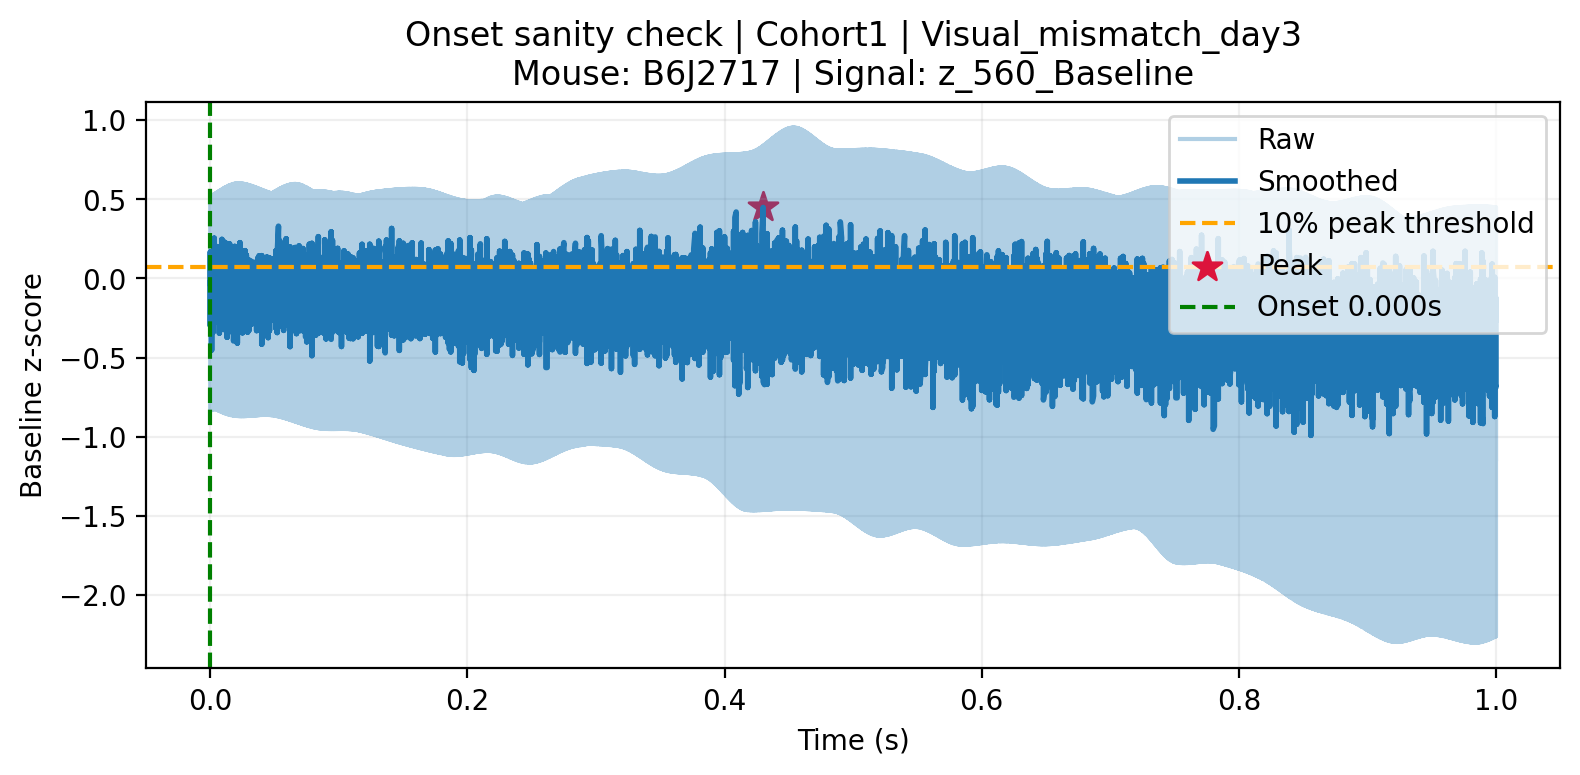

In [124]:
# SANITY CHECK: VISUALISE ONSET DETECTION FOR ONE MOUSE
#---------------------------------------------------------------------------------------------------#
def plot_onset_detection_sanity_check(
    mouse_id: str,
    signal_column: str,
    window: Tuple[float, float],
    mouse_frames: Dict[str, pd.DataFrame],
    reference_label: str,
) -> None:
    if mouse_id not in mouse_frames:
        print(f"⚠️ Mouse '{mouse_id}' not found in the available frames: {sorted(mouse_frames.keys())}")
        return

    mouse_df = mouse_frames[mouse_id]
    if signal_column not in mouse_df.columns:
        print(f"⚠️ Signal '{signal_column}' not present for mouse '{mouse_id}'.")
        return

    df_signal = _prepare_mouse_signal_frame(mouse_df, signal_column)
    if df_signal.empty:
        print(f"⚠️ No data available for mouse '{mouse_id}' and signal '{signal_column}'.")
        return

    window_mask = (df_signal["time"] >= window[0]) & (df_signal["time"] <= window[1])
    window_df = df_signal.loc[window_mask]
    if window_df.empty:
        print(f"⚠️ Window {window} yielded no data points for mouse '{mouse_id}'.")
        return

    times = window_df["time"].to_numpy(dtype=float)
    values = window_df["value"].to_numpy(dtype=float)
    finite_mask = np.isfinite(times) & np.isfinite(values)
    times = times[finite_mask]
    values = values[finite_mask]
    if values.size == 0:
        print(f"⚠️ No finite values available for plotting (mouse '{mouse_id}').")
        return

    smooth_window = min(7, values.size)
    if smooth_window > 1:
        kernel = np.ones(smooth_window, dtype=float) / smooth_window
        smoothed = np.convolve(values, kernel, mode="same")
    else:
        smoothed = values.copy()

    candidate = smoothed
    candidate_std = float(np.nanstd(candidate)) if candidate.size else 0.0
    prominence = max(0.05, 0.15 * candidate_std) if candidate_std > 0 else 0.05

    peaks, _ = find_peaks(candidate, prominence=prominence)
    if peaks.size == 0:
        peaks, _ = find_peaks(candidate)
    if peaks.size == 0:
        peak_index = int(np.nanargmax(candidate))
    else:
        best_idx = int(np.argmax(candidate[peaks]))
        peak_index = int(peaks[best_idx])
    peak_index = max(0, min(peak_index, values.size - 1))

    peak_value_raw = values[peak_index]
    peak_value_smooth = candidate[peak_index]
    peak_value = max(peak_value_raw, peak_value_smooth)

    logistic_onset = _estimate_logistic_onset(times[: peak_index + 1], candidate[: peak_index + 1])
    if logistic_onset is not None:
        onset_time = float(logistic_onset)
        onset_threshold = peak_value * 0.1
    else:
        onset_time = np.nan
        onset_threshold = peak_value * 0.1
        for idx in range(0, peak_index + 1):
            current_value = candidate[idx]
            if not np.isfinite(current_value):
                continue
            if current_value >= onset_threshold:
                if idx == 0:
                    onset_time = times[idx]
                else:
                    prev_time = times[idx - 1]
                    prev_value = candidate[idx - 1]
                    if not np.isfinite(prev_value) or prev_value == current_value:
                        onset_time = times[idx]
                    else:
                        fraction = (onset_threshold - prev_value) / (current_value - prev_value)
                        onset_time = prev_time + fraction * (times[idx] - prev_time)
                break

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(times, values, color="#1f77b4", alpha=0.35, label="Raw")
    ax.plot(times, candidate, color="#1f77b4", linewidth=2, label="Smoothed")
    ax.axhline(onset_threshold, color="orange", linestyle="--", label="10% peak threshold")
    ax.scatter(times[peak_index], candidate[peak_index], color="crimson", marker="*", s=120, label="Peak")
    if np.isfinite(onset_time):
        ax.axvline(onset_time, color="green", linestyle="--", label=f"Onset {onset_time:.3f}s")
    else:
        ax.text(0.05, 0.9, "Onset not found", transform=ax.transAxes, color="red", fontsize=12)

    ax.set_title(f"Onset sanity check | {reference_label}\nMouse: {mouse_id} | Signal: {signal_column}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Baseline z-score")
    ax.grid(True, alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), loc="upper right")
    plt.tight_layout()
    plt.show()


if 'mouse_signal_frames' in locals() and mouse_signal_frames:
    sanity_mouse = selected_mice[0] if selected_mice else next(iter(mouse_signal_frames.keys()))
    plot_onset_detection_sanity_check(
        sanity_mouse,
        'z_560_Baseline',
        POST_ALIGNMENT_WINDOW,
        mouse_signal_frames,
        reference_label=f"{cohort_identifier} | {experiment_day}",
    )
else:
    print("⚠️ No mouse signal frames available for onset sanity check.")


In [ ]:
# APPLY HALT VS NO HALT CONDITION COMPARISON
#---------------------------------------------------------------------------------------------------#
if GENERATE_CONDITION_COMPARISON:
    print(f"\n{'='*60}")
    print("HALT VS NO HALT CONDITION COMPARISON")
    print(f"{'='*60}")

    condition_metrics_frames: Dict[str, pd.DataFrame] = {}
    condition_sources_map: Dict[str, Dict[str, Path]] = {}

    for condition_key, cfg in CONDITION_COMPARISON_CONFIG.items():
        metrics_df_condition, sources_condition = compute_condition_signal_metrics(
            condition_key,
            cfg,
            selected_mice,
            available_mice,
        )
        if metrics_df_condition.empty:
            print(f"⚠️ Skipping condition '{condition_key}' (no metrics computed).")
            continue
        condition_metrics_frames[condition_key] = metrics_df_condition
        condition_sources_map[condition_key] = sources_condition
        print(
            f"✅ Condition '{condition_key}' loaded: "
            f"{metrics_df_condition['mouse'].nunique()} mice, "
            f"{metrics_df_condition['signal'].nunique()} signals."
        )

    if len(condition_metrics_frames) < 2:
        print("⚠️ At least two conditions are required for comparison. Skipping analysis.")
    else:
        combined_metrics_wide = pd.concat(
            condition_metrics_frames.values(), ignore_index=True
        )

        long_df = combined_metrics_wide.melt(
            id_vars=[
                "mouse",
                "signal",
                "condition",
                "condition_label",
                "event_name",
            ],
            value_vars=COMPARISON_METRICS,
            var_name="metric",
            value_name="value",
        )
        long_df = (
            long_df.groupby(
                ["mouse", "signal", "condition", "condition_label", "event_name", "metric"],
                as_index=False,
            )["value"]
            .mean()
        )
        long_df = long_df.dropna(subset=["value"])

        # Focus comparisons on z_560_Baseline only
        long_df = long_df[long_df["signal"] == "z_560_Baseline"].copy()
        if long_df.empty:
            print("⚠️ No z_560_Baseline data available for comparison; skipping analysis.")
        else:
            condition_order = list(CONDITION_COMPARISON_CONFIG.keys())
            preferred_order = ["No_halt", "Apply_halt_2s"]
            condition_order = (
                [cond for cond in preferred_order if cond in condition_order]
                + [cond for cond in condition_order if cond not in preferred_order]
            )

            signal_order = sorted(long_df["signal"].unique())

            paired_mice_sets = [
                set(long_df[long_df["condition"] == cond]["mouse"].unique())
                for cond in condition_order
                if cond in long_df["condition"].unique()
            ]
            paired_mice = set.intersection(*paired_mice_sets) if paired_mice_sets else set()

            if not paired_mice:
                print("⚠️ No mice have data in all conditions. Skipping paired analysis.")
            else:
                long_df = long_df[long_df["mouse"].isin(paired_mice)].copy()
                long_df["mouse"] = long_df["mouse"].astype(str)

                condition_label_map = (
                    long_df.drop_duplicates(subset=["condition", "condition_label"])
                    .set_index("condition")["condition_label"]
                    .to_dict()
                )
                long_df["condition_label"] = long_df["condition"].map(condition_label_map)

                mouse_colors = assign_mouse_colors_consistent(paired_mice)
                comparison_output_dir = Path(main_data_dir) / "halt_vs_no_halt_comparison"
                comparison_output_dir.mkdir(parents=True, exist_ok=True)

                print(
                    f"Analyzing {len(paired_mice)} paired mice across "
                    f"{len(signal_order)} signals for metrics: {COMPARISON_METRICS}"
                )

                for metric_name in COMPARISON_METRICS:
                    metric_long = long_df[long_df["metric"] == metric_name].copy()
                    if metric_long.empty:
                        print(f"⚠️ No data for metric '{metric_name}', skipping.")
                        continue

                    summary_df, pairwise_df, analysis_notes = compute_repeated_measures_stats(
                        metric_long,
                        condition_order,
                        signal_order,
                        metric_name,
                    )

                    fig = plot_condition_metric(
                        metric_name,
                        metric_long,
                        condition_order,
                        signal_order,
                        mouse_colors,
                    )

                    cohort_part = sanitize_for_filename(cohort_identifier, "cohort")
                    day_part = sanitize_for_filename(experiment_day, "day")
                    metric_part = sanitize_for_filename(metric_name, metric_name)

                    plot_filename = (
                        comparison_output_dir
                        / f"{cohort_part}_{day_part}_{metric_part}_halt_vs_nohalt_comparison.pdf"
                    )
                    fig.savefig(plot_filename, dpi=300, bbox_inches="tight")
                    plt.close(fig)

                    plot_data_path = (
                        comparison_output_dir
                        / f"{cohort_part}_{day_part}_{metric_part}_halt_vs_nohalt_plot_data.csv"
                    )
                    metric_long.sort_values(
                        ["signal", "mouse", "condition"]
                    ).to_csv(plot_data_path, index=False)

                    stats_frames = []
                    if not summary_df.empty:
                        stats_frames.append(summary_df)
                    if not pairwise_df.empty:
                        stats_frames.append(pairwise_df)
                    if analysis_notes:
                        stats_frames.append(
                            pd.DataFrame(
                                {
                                    "analysis": ["note"] * len(analysis_notes),
                                    "metric": [metric_name] * len(analysis_notes),
                                    "note": analysis_notes,
                                }
                            )
                        )

                    if stats_frames:
                        stats_output = pd.concat(stats_frames, ignore_index=True)
                    else:
                        stats_output = pd.DataFrame(
                            {
                                "analysis": ["note"],
                                "metric": [metric_name],
                                "note": ["No statistics computed."],
                            }
                        )

                    stats_output["cohort"] = cohort_identifier
                    stats_output["experiment_day"] = experiment_day
                    stats_output["paired_mice_n"] = len(paired_mice)
                    stats_output_path = (
                        comparison_output_dir
                        / f"{cohort_part}_{day_part}_{metric_part}_halt_vs_nohalt_stats.csv"
                    )
                    stats_output.to_csv(stats_output_path, index=False)

                    print(
                        f"📄 Metric '{metric_name}': saved plot ({plot_filename.name}), "
                        f"data ({plot_data_path.name}), stats ({stats_output_path.name})"
                    )

                print(
                    f"✅ Condition comparison outputs saved to: {comparison_output_dir}"
                )
else:
    print("⏭️  Condition comparison disabled (GENERATE_CONDITION_COMPARISON=False)")

In [126]:
# GRAND AVERAGE VS PER-MOUSE PEAK OVERLAY
#---------------------------------------------------------------------------------------------------#
def plot_grand_average_vs_peaks(
    grand_mean: pd.Series,
    grand_sem: pd.Series,
    per_mouse_metrics: pd.DataFrame,
    signal: str,
    condition_label: str,
    cohort_identifier: str,
    experiment_day: str,
    output_dir: Path,
    reference_time: Optional[float] = None,
) -> Optional[Path]:
    """Plot the grand-average trace with per-mouse peak overlay and save to disk."""
    if grand_mean is None or grand_mean.empty:
        print(f"⚠️ Grand-average data unavailable for signal '{signal}'.")
        return None

    if grand_sem is None or grand_sem.empty:
        grand_sem = pd.Series(0.0, index=grand_mean.index)

    peaks = (
        per_mouse_metrics[per_mouse_metrics["signal"] == signal]["peak"].apply(pd.to_numeric, errors="coerce")
        if "signal" in per_mouse_metrics.columns
        else pd.Series(dtype=float)
    )
    peaks = peaks.dropna()
    if peaks.empty:
        print(f"⚠️ No per-mouse peak values available for signal '{signal}'.")
        return None

    peak_mean = float(peaks.mean())
    peak_sem = float(peaks.std(ddof=1) / np.sqrt(len(peaks))) if len(peaks) > 1 else 0.0

    time_points = pd.to_numeric(grand_mean.index, errors="coerce")
    values = pd.to_numeric(grand_mean.values, errors="coerce")
    sem_values = pd.to_numeric(grand_sem.reindex(grand_mean.index).fillna(0).values, errors="coerce")

    valid_mask = np.isfinite(time_points) & np.isfinite(values) & np.isfinite(sem_values)
    time_points = time_points[valid_mask]
    values = values[valid_mask]
    sem_values = sem_values[valid_mask]

    if time_points.size == 0:
        print(f"⚠️ Grand-average data for signal '{signal}' contains no finite values.")
        return None

    if reference_time is None:
        peak_idx = int(np.argmax(values))
        reference_time = float(time_points[peak_idx])

    jitter = np.linspace(-0.15, 0.15, len(peaks)) if len(peaks) > 1 else np.array([0.0])
    scatter_x = reference_time + jitter

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(time_points, values, color="black", linewidth=2, label="Grand average")
    ax.fill_between(time_points, values - sem_values, values + sem_values, color="grey", alpha=0.25, label="Grand avg ± SEM")

    band_bottom = peak_mean - peak_sem
    band_top = peak_mean + peak_sem
    ax.axhspan(band_bottom, band_top, color="#d62728", alpha=0.15, label="Per-mouse peak mean ± SEM")
    ax.axhline(peak_mean, color="#d62728", linestyle="--", linewidth=2)
    ax.scatter(scatter_x, peaks.values, color="#d62728", edgecolors="black", linewidths=0.8, s=55, zorder=5, label="Per-mouse peaks")

    annotation = (
        f"Per-mouse peak mean = {peak_mean:.3f}\n"
        f"SEM = {peak_sem:.3f}\n"
        f"n = {len(peaks)}"
    )
    ax.text(
        0.02,
        0.98,
        annotation,
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85),
    )

    ax.set_title(f"{signal.replace('_', ' ')} | {condition_label}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("z-score")
    ax.grid(True, alpha=0.2)

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), loc="lower right")

    plt.tight_layout()

    output_dir.mkdir(parents=True, exist_ok=True)
    cohort_part = sanitize_for_filename(cohort_identifier, "cohort")
    day_part = sanitize_for_filename(experiment_day, "day")
    signal_part = sanitize_for_filename(signal, signal)
    condition_part = sanitize_for_filename(condition_label, "condition")
    output_path = output_dir / f"{cohort_part}_{day_part}_{signal_part}_{condition_part}_grand_vs_peaks.pdf"
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"✅ Grand-average vs peaks plot saved to: {output_path}")
    return output_path


if 'results' in locals() and results and 'grand_averages' in results:
    grand_avg_df = results['grand_averages']
    grand_sem_df = results.get('grand_sems', pd.DataFrame())
    target_signal = 'z_560_Baseline'

    if target_signal in grand_avg_df.columns:
        condition_metrics_source: Optional[pd.DataFrame] = None
        if 'condition_metrics_frames' in locals() and isinstance(condition_metrics_frames, dict):
            condition_metrics_source = condition_metrics_frames.get('Apply_halt_2s')
            if condition_metrics_source is not None:
                condition_metrics_source = condition_metrics_source.copy()
        if (condition_metrics_source is None or condition_metrics_source.empty) and 'signal_metrics_df' in locals():
            condition_metrics_source = signal_metrics_df.copy()

        if condition_metrics_source is not None and not condition_metrics_source.empty:
            apply_mask = pd.Series(True, index=condition_metrics_source.index)
            if 'condition' in condition_metrics_source.columns:
                apply_mask &= condition_metrics_source['condition'] == 'Apply_halt_2s'
            per_mouse_subset = condition_metrics_source[apply_mask].copy()
            if per_mouse_subset.empty:
                per_mouse_subset = condition_metrics_source.copy()

            output_base_dir = Path(main_data_dir) / 'halt_vs_no_halt_comparison'
            plot_grand_average_vs_peaks(
                grand_avg_df[target_signal],
                grand_sem_df[target_signal] if isinstance(grand_sem_df, pd.DataFrame) and target_signal in grand_sem_df.columns else pd.Series(0, index=grand_avg_df.index),
                per_mouse_subset,
                target_signal,
                'Apply halt 2s',
                cohort_identifier,
                experiment_day,
                output_base_dir,
                reference_time=POST_ALIGNMENT_WINDOW_START + POST_ALIGNMENT_WINDOW_DURATION / 2,
            )
        else:
            print("⚠️ No per-mouse metrics available to overlay with the grand-average trace.")
    else:
        print(f"⚠️ Grand averages do not include signal '{target_signal}'.")
else:
    print("⚠️ Results with grand averages are unavailable; skipping grand-average vs peak plot.")


✅ Grand-average vs peaks plot saved to: /Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3/halt_vs_no_halt_comparison/Cohort1_Visual_mismatch_day3_z_560_Baseline_Apply_halt_2s_grand_vs_peaks.pdf
